In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import ROOT
import rootpy
import root_numpy
import uproot

/opt/conda/anaconda3/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


## Detector

![title](img/juno.png)

![title](img/juno2.png)

More:
http://juno.ihep.cas.cn/ATEjuno/201309/t20130912_109433.html

## Data description

lpmt — большие ФЭУ, spmt — маленькие,
hits — зарегистрированные фото-электроны (не все фотоны выбивают фото-электрон, и не всякий фото-электрон регистрируется)
Каждый hit имеет 3 характеристики: номер ФЭУ (pmtID), время от физического события в детекторе (hitTime) и происхождение (isDN=0 для нормальных хитов, isDN=1 для шума в самих ФЭУ).

В каждом физическом событии может быть переменное количество хитов. Количество хитов сохранено в переменной nHits. Технически nHits — это длина массивов pmtID, hitTime и isDN в каждом событии.

В true_info записаны данные, которые нельзя напрямую измерить, но можно предсказывать: E — энергия в МэВ; x,y,z,R — координаты в мм (R^2 = x^2+y^2+z^2). События в деревьях соответствуют друг другу по порядковому номеру: певрое из true_info соответствует первому из lpmt_hits и первому из spmt_hits.

lpmt_pos и spmt_pos — это координаты ФЭУ (x, y, z в миллиметрах).

## Goals

* Классификация шумовых событий и реальных, т.к. ФЭУ могут срабатывать случайно
* Восстановление энергии или положения

## Exploratory Data Analysis

In [3]:
lpmt_hits = pd.read_hdf('../data/lpmt_hits.h5', mode='r') 
lpmt_hits.shape

(929768817, 4)

In [4]:
lpmt_hits.head()

event     hitTime   isDN  pmtID
0      0  249.992615  False  14175
1      0   40.010311  False  17319
2      0  162.123199  False  16882
3      0   51.875614  False  14951
4      0   79.817497  False  10947

In [5]:
spmt_hits = pd.read_hdf('../data/spmt_hits.h5', mode='r')
spmt_hits.shape

(33958478, 4)

In [6]:
spmt_hits.head()

event     hitTime   isDN   pmtID
0      0   37.040001  False  318069
1      0  238.278091  False  311819
2      0  103.316055  False  307244
3      0  108.034225  False  323230
4      0   36.505154  False  320568

In [7]:
true_info = pd.read_csv('true_info.csv') 
true_info.shape

(100000, 6)

In [8]:
true_info.head()

E          R  evtID           x           y           z
0  4.747791  14610.378      0   8290.7790  11995.6180   911.74286
1  3.919721  14630.141      1  11397.6320   5407.4497 -7409.08200
2  6.823932  14573.132      2  14063.3380  -3812.8540   246.65280
3  3.765940  16820.080      3  -2377.9307 -16317.7020  3315.59030
4  3.217473  13026.938      4  -8617.1170    868.5116  9730.98600

In [9]:
lpmt_pos = pd.read_csv('lpmt_pos.csv') 
lpmt_pos.shape

(17739, 4)

In [10]:
lpmt_pos.head()

pmt_id         pmt_x      pmt_y     pmt_z
0       0  1.049021e+03     0.0000  19171.32
1       1  9.084785e+02   524.5103  19171.32
2       2  5.245103e+02   908.4785  19171.32
3       3  6.423399e-14  1049.0206  19171.32
4       4 -5.245103e+02   908.4785  19171.32

In [11]:
spmt_pos = pd.read_csv('spmt_pos.csv') 
spmt_pos.shape

(24952, 4)

In [12]:
spmt_pos.head()

pmt_id         pmt_x       pmt_y      pmt_z
0  300000  1.384810e+03   244.17944  19148.438
1  300001  1.217782e+03   703.08670  19148.438
2  300002  9.038709e+02  1077.19130  19148.438
3  300003  4.809396e+02  1321.37070  19148.438
4  300004  8.610328e-14  1406.17330  19148.438

In [13]:
event_id = 10000
lpmt_event_hits = lpmt_hits.loc[lpmt_hits['event'] == event_id]
spmt_event_hits = spmt_hits.loc[spmt_hits['event'] == event_id]

In [14]:
lpmt_hits_values = lpmt_event_hits['pmtID'].values
spmt_hits_values = spmt_event_hits['pmtID'].values

In [15]:
lpmt_hits_mask = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values:
        lpmt_hits_mask.append("g")
    else:
        lpmt_hits_mask.append("r")
        
spmt_hits_mask = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values:
        spmt_hits_mask.append("g")
    else:
        spmt_hits_mask.append("r")

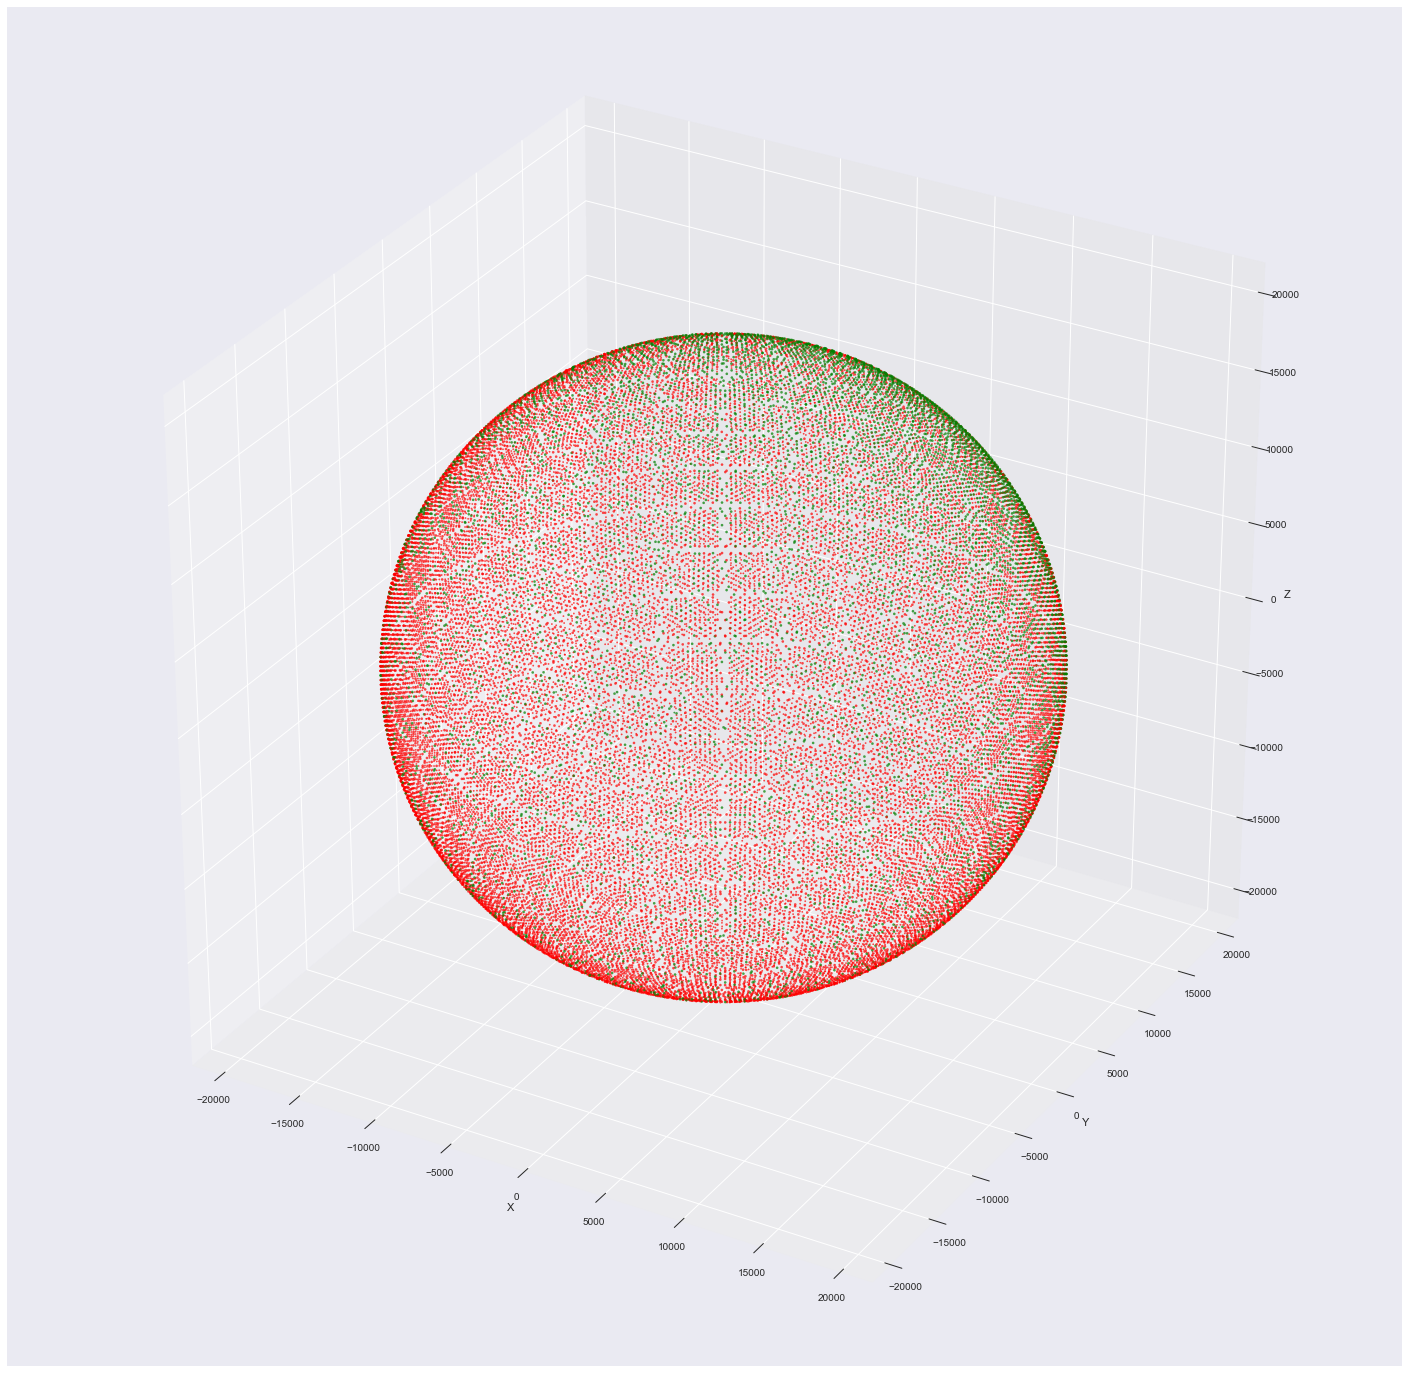

In [16]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Signal without DN

In [17]:
lpmt_event_hits_without_DN = lpmt_event_hits.loc[lpmt_event_hits['isDN'] == False]
spmt_event_hits_without_DN = spmt_event_hits.loc[spmt_event_hits['isDN'] == False]

In [18]:
lpmt_hits_values2 = lpmt_event_hits_without_DN['pmtID'].values
spmt_hits_values2 = lpmt_event_hits_without_DN ['pmtID'].values

In [19]:
lpmt_hits_mask2 = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values2:
        lpmt_hits_mask2.append("g")
    else:
        lpmt_hits_mask2.append("r")
        
spmt_hits_mask2 = []
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values2:
        spmt_hit_mask2.append("g")
    else:
        spmt_hits_mask2.append("r")

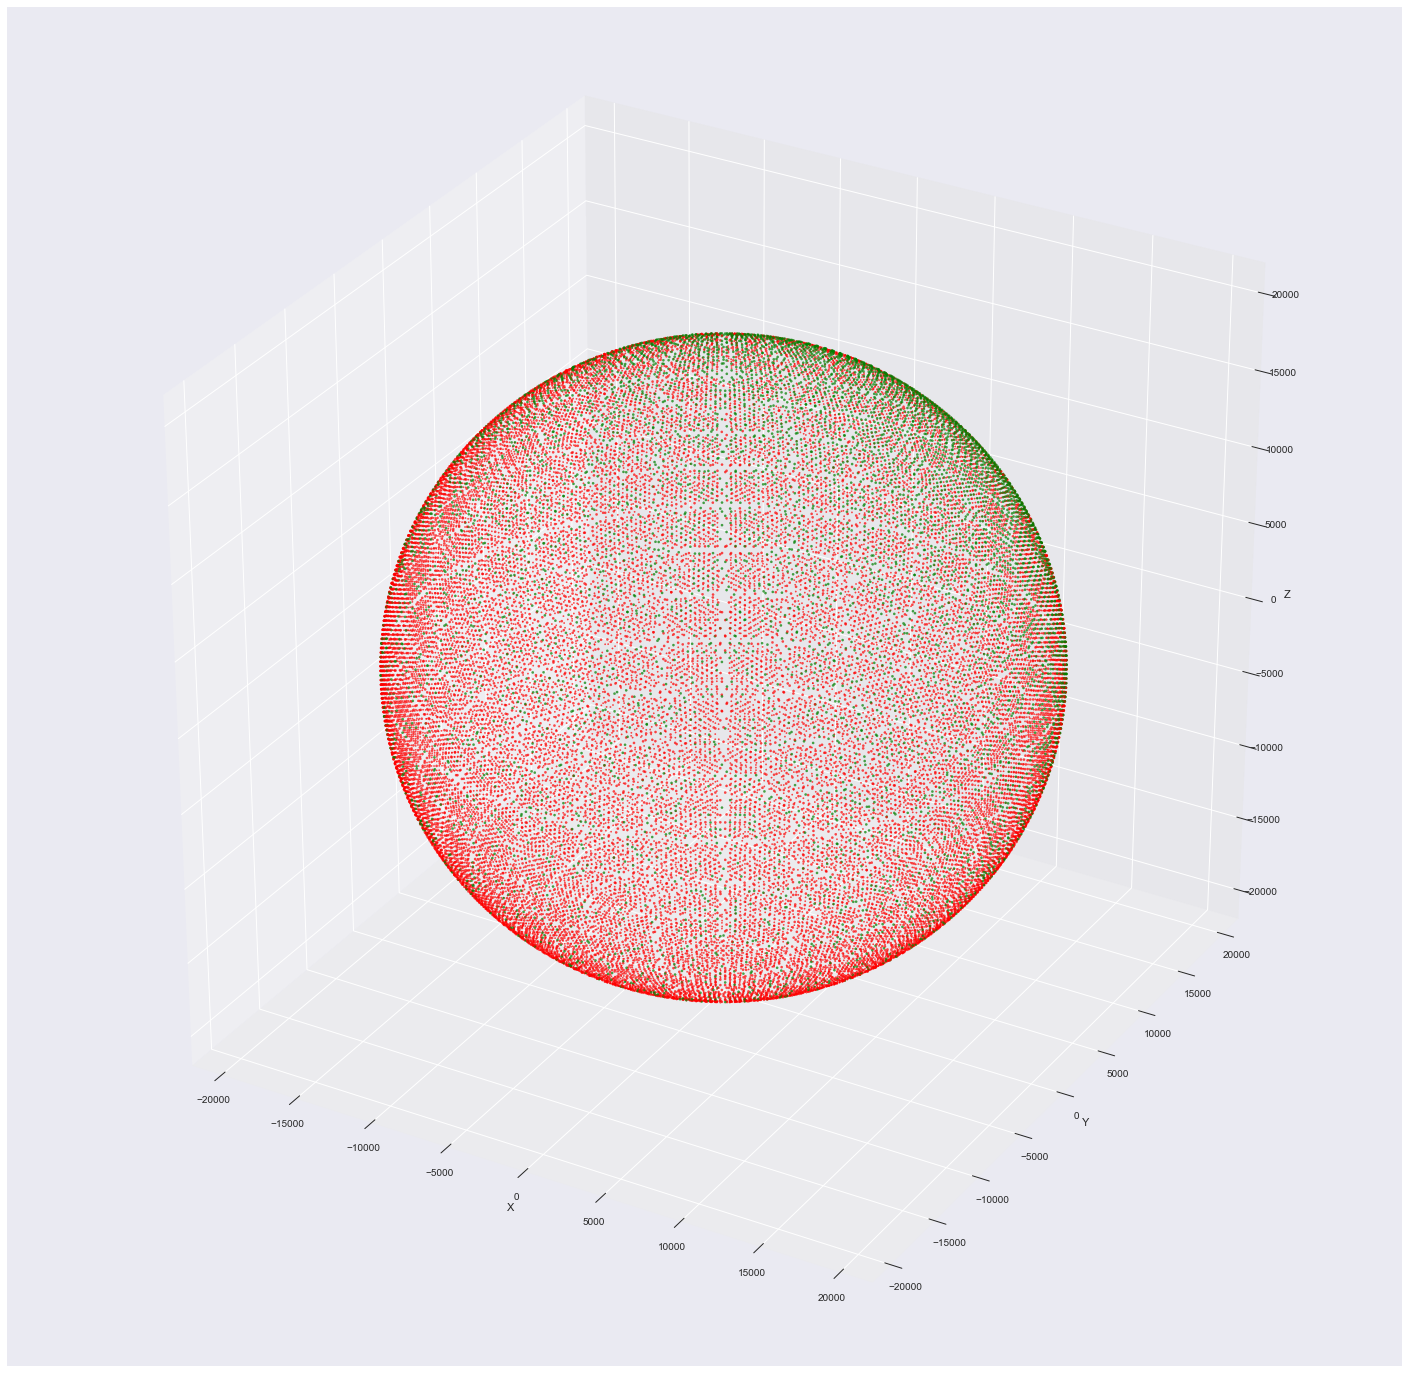

In [20]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = lpmt_pos['pmt_x']
y = lpmt_pos['pmt_y']
z = lpmt_pos['pmt_z']

ax.scatter(x, y, z, c=lpmt_hits_mask2, marker='o', s=5, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x = spmt_pos['pmt_x']
y = spmt_pos['pmt_y']
z = spmt_pos['pmt_z']

ax.scatter(x, y, z, c=spmt_hits_mask2, marker='o', s=2, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Only signal

In [21]:
x = []
y = []
z = []
for t in lpmt_pos.itertuples():
    if t[1] in lpmt_hits_values2:
        x.append(t[2])
        y.append(t[3])
        z.append(t[4])
        
for t in spmt_pos.itertuples():
    if t[1] in spmt_hits_values2:
        x.append(t[2])
        y.append(t[3])
        z.append(t[4])

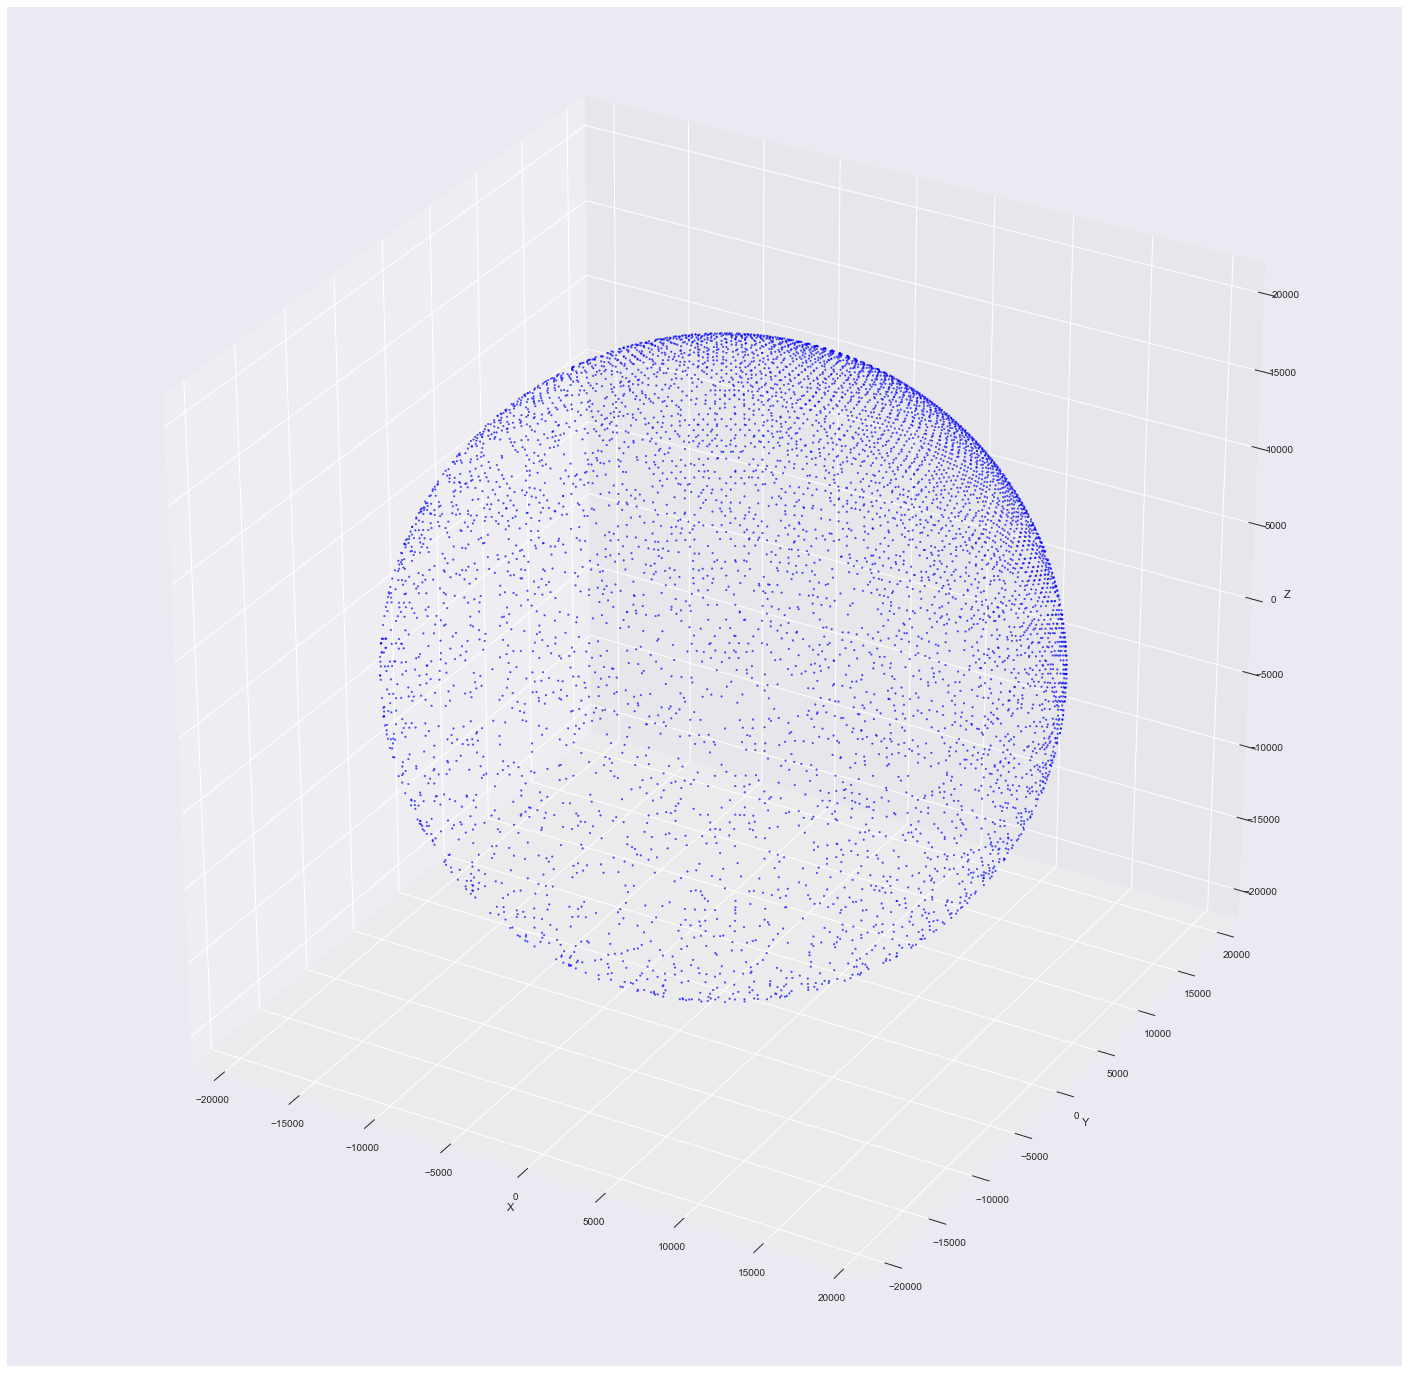

In [22]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b', marker='o', s=3, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Signal by time

In [23]:
lpmt_time = lpmt_event_hits_without_DN['hitTime'].values
print(min(lpmt_time))
print(max(lpmt_time))

18.51124
889.8253


In [24]:
spmt_time = spmt_event_hits_without_DN['hitTime'].values
print(min(spmt_time))
print(max(spmt_time))

19.61353
790.9525


In [25]:
n = 20
time_ints = np.linspace(min(lpmt_time), max(lpmt_time), num=n) 
time_ints 

array([ 18.51124001,  64.36987566, 110.22851131, 156.08714696,
       201.94578261, 247.80441826, 293.66305391, 339.52168957,
       385.38032522, 431.23896087, 477.09759652, 522.95623217,
       568.81486782, 614.67350347, 660.53213913, 706.39077478,
       752.24941043, 798.10804608, 843.96668173, 889.82531738])

In [26]:
true_event = true_info[true_info['evtID'] == event_id][['x', 'y', 'z']].values[0]

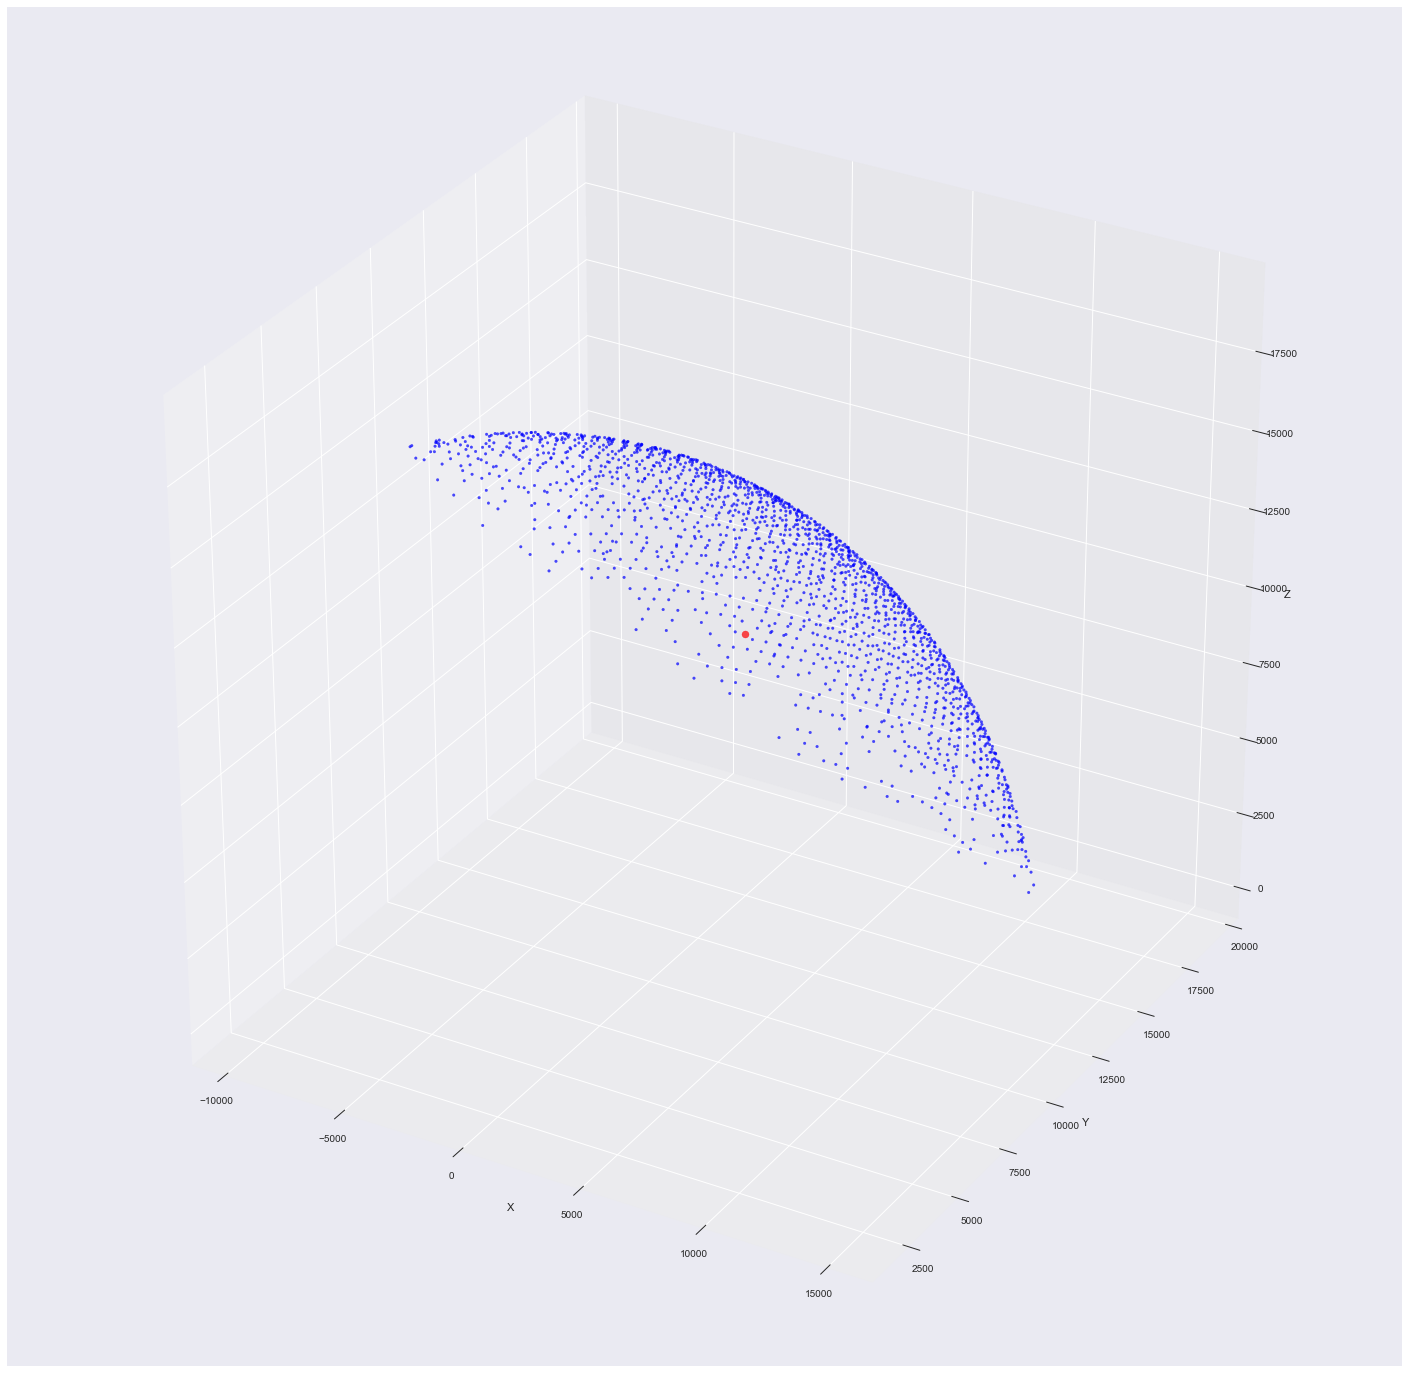

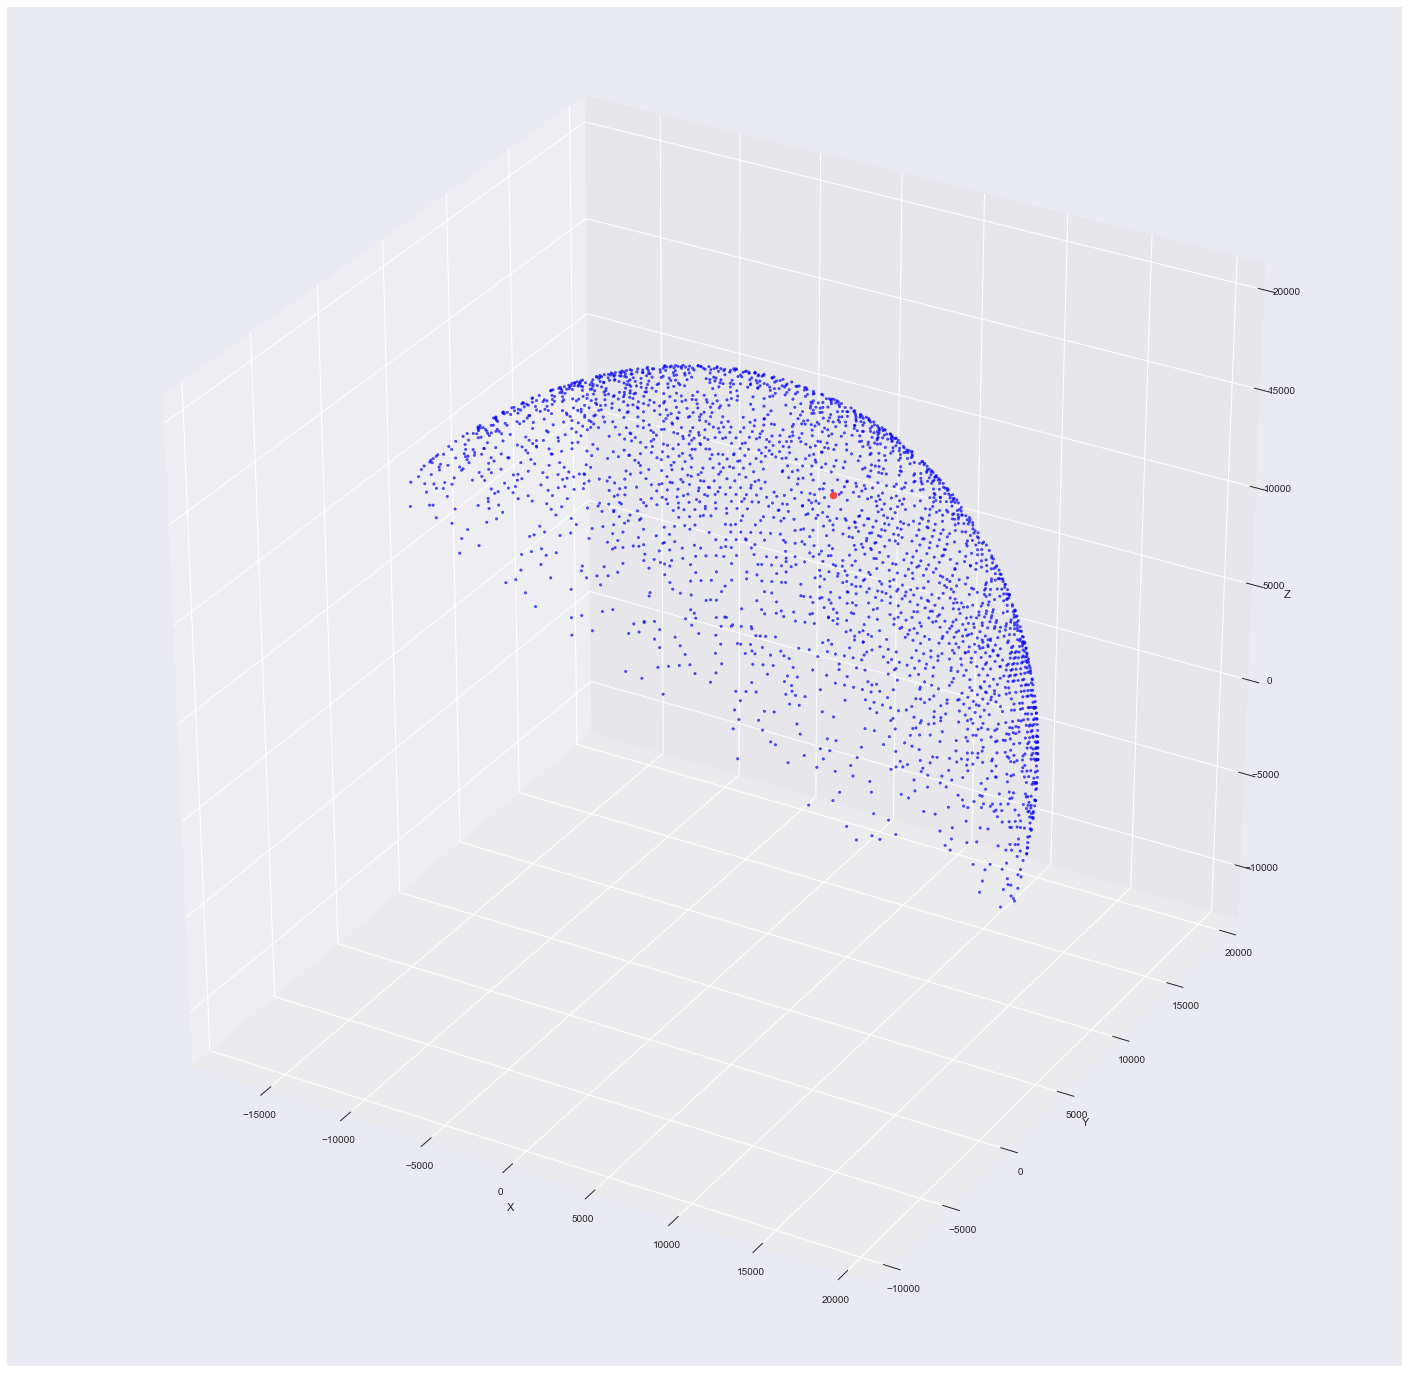

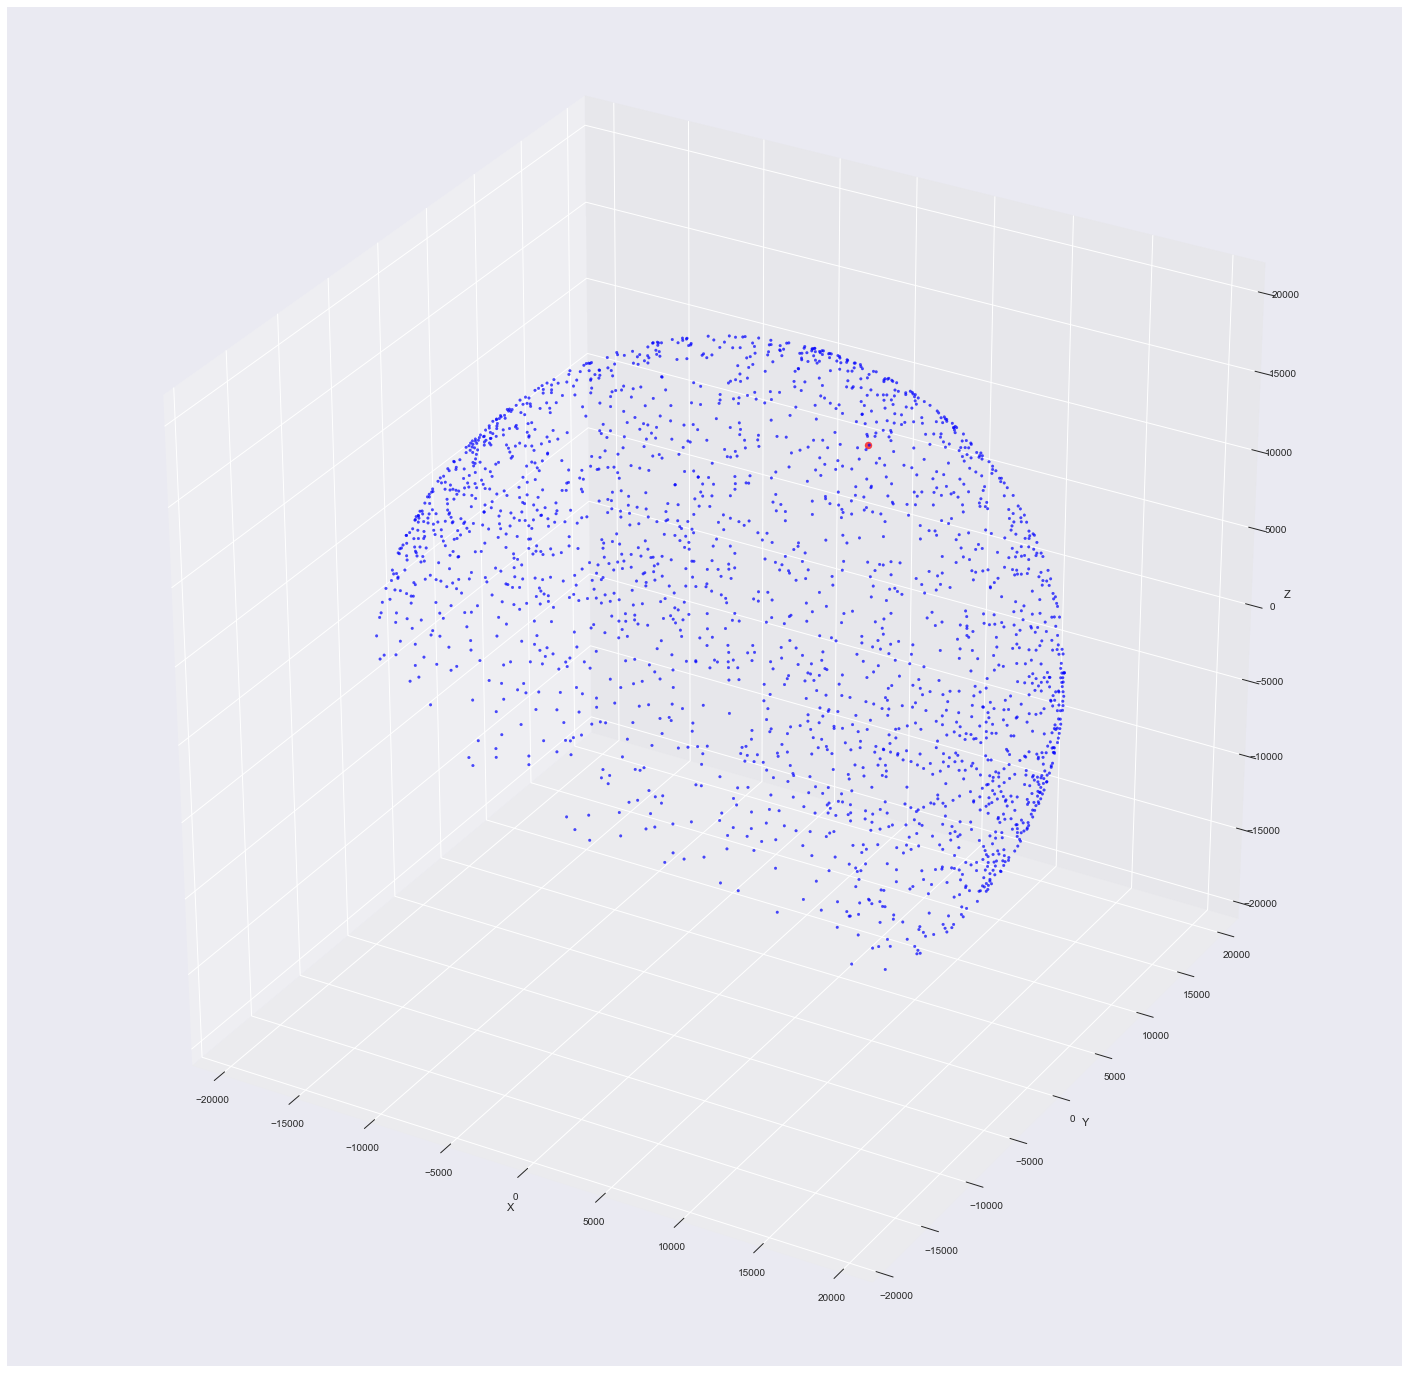

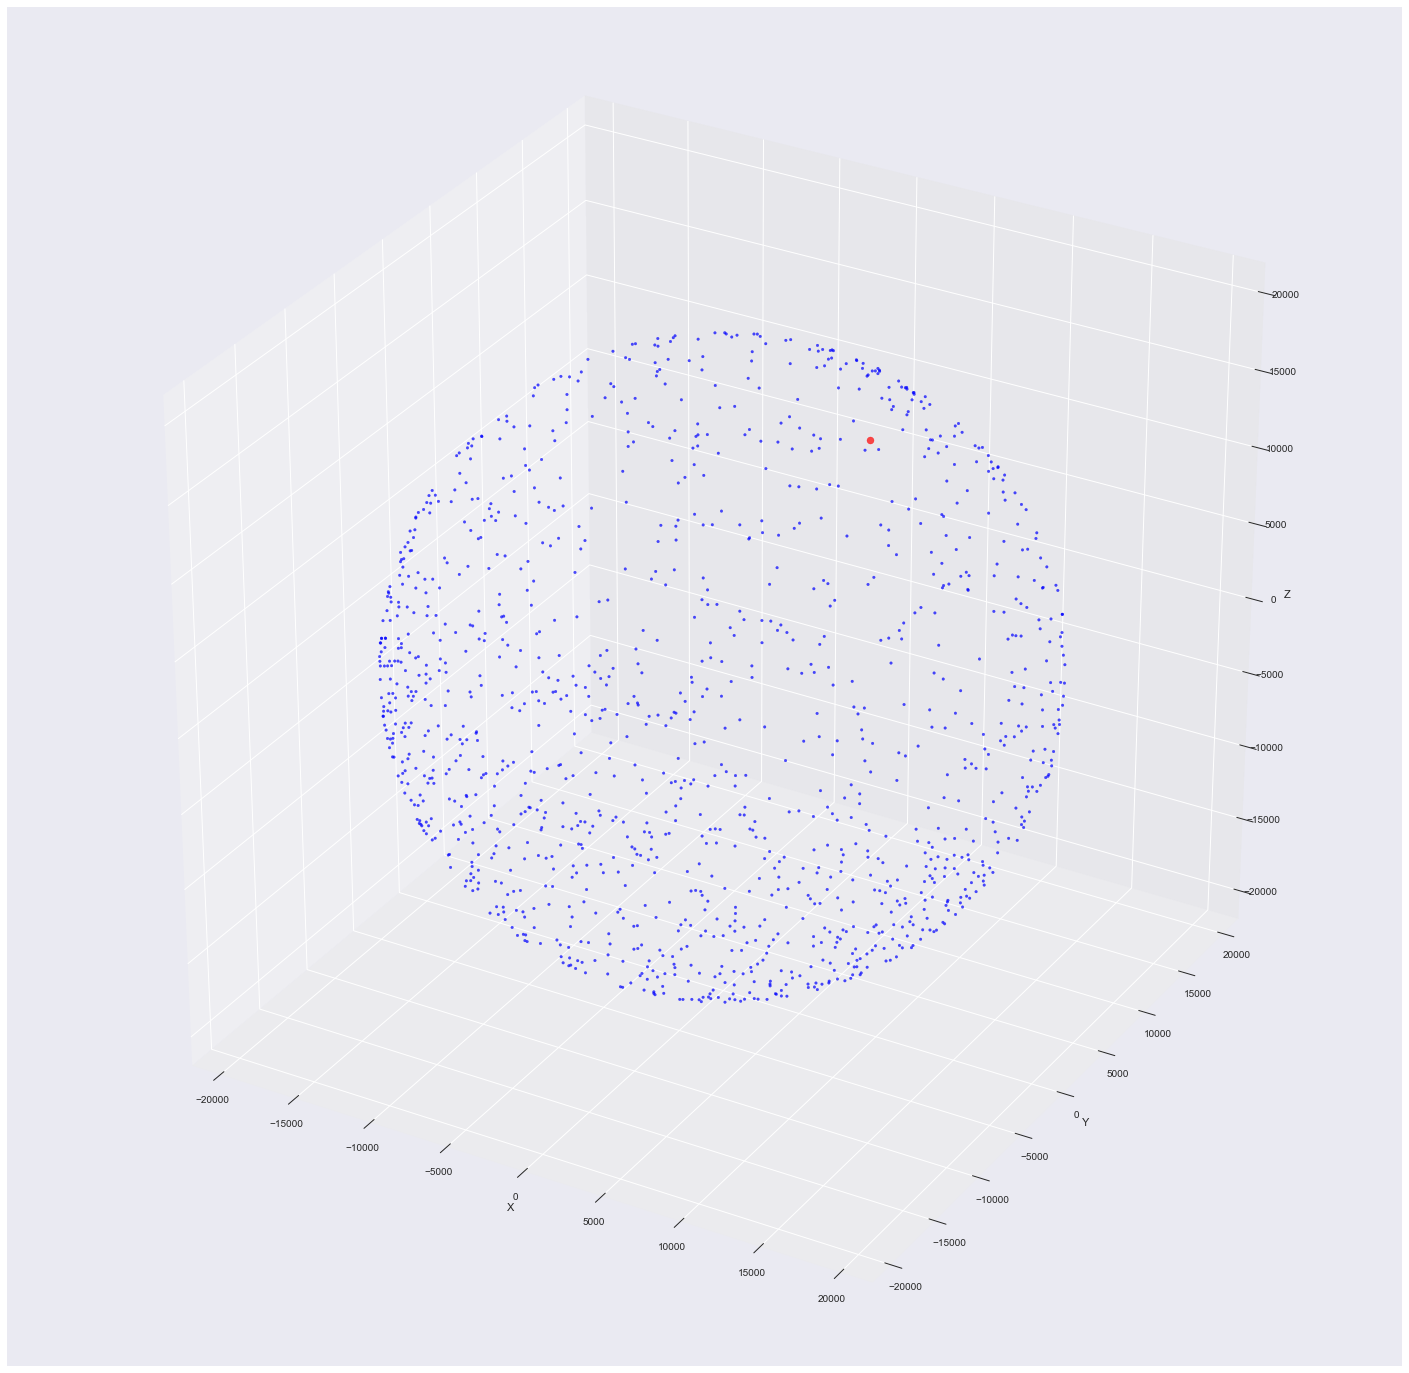

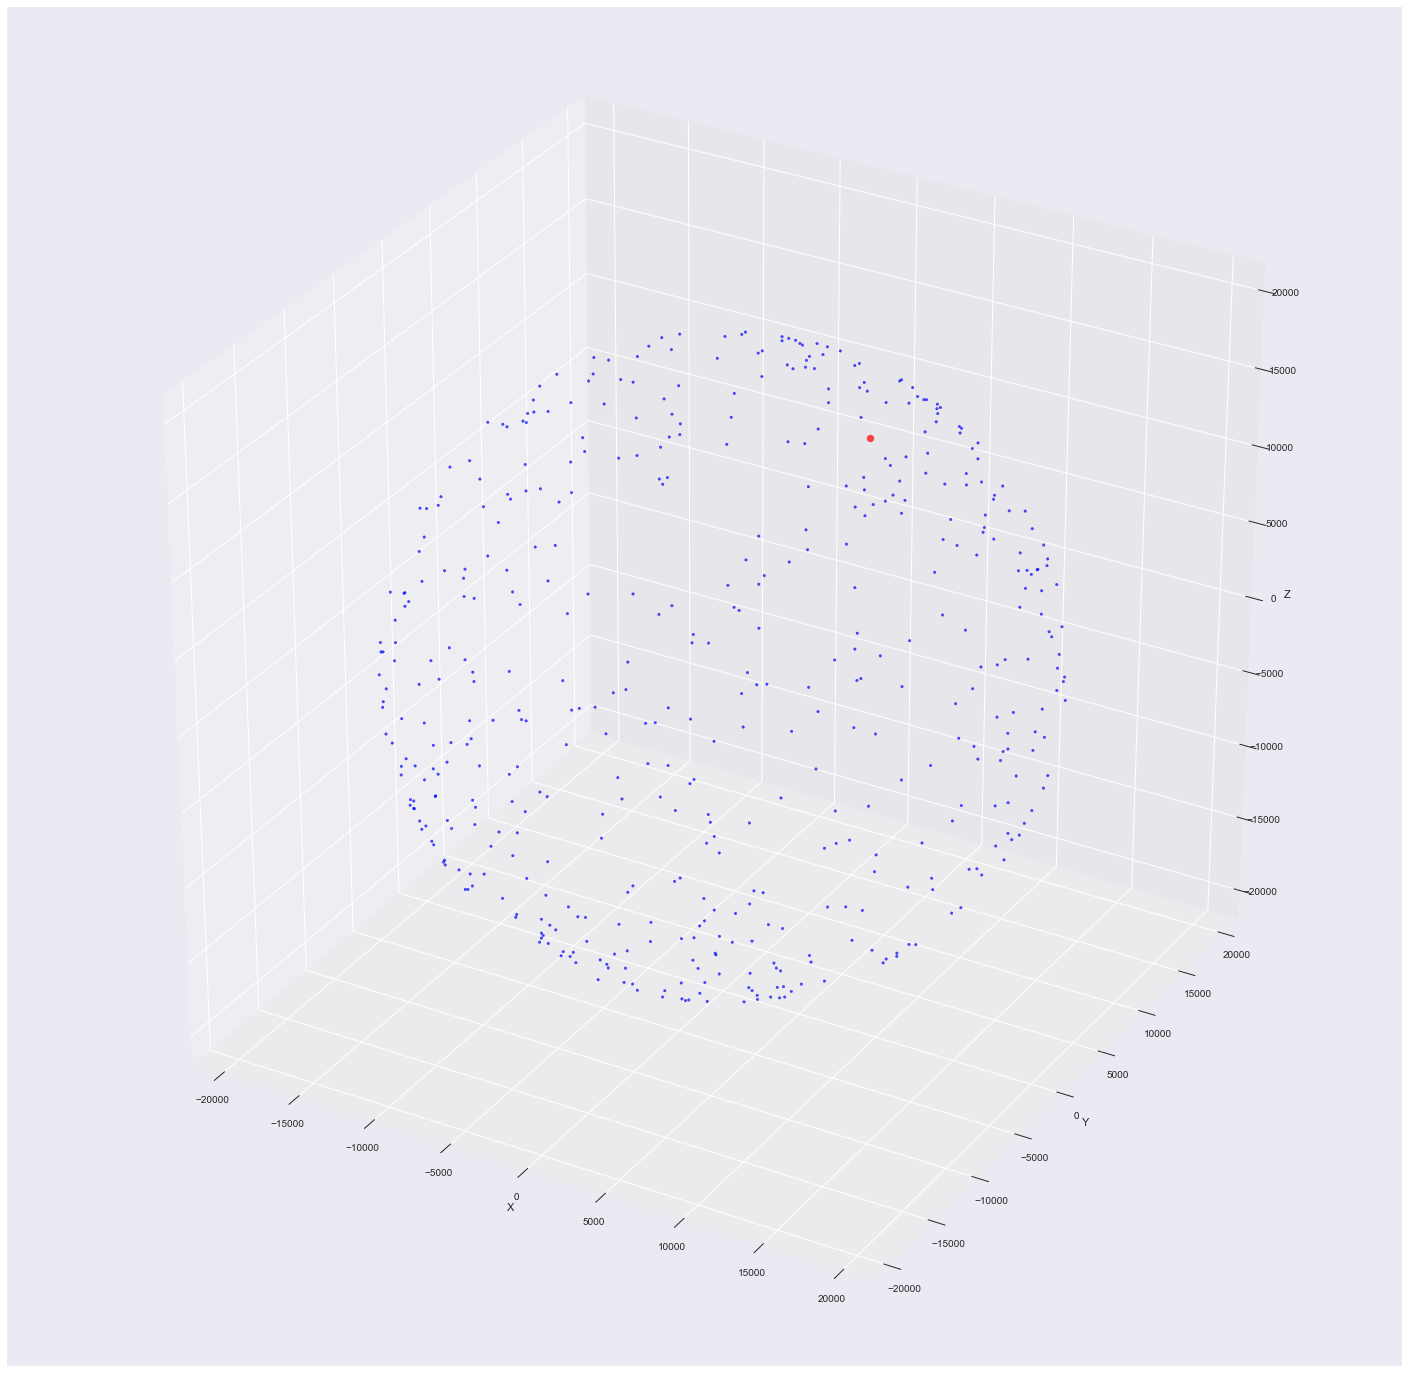

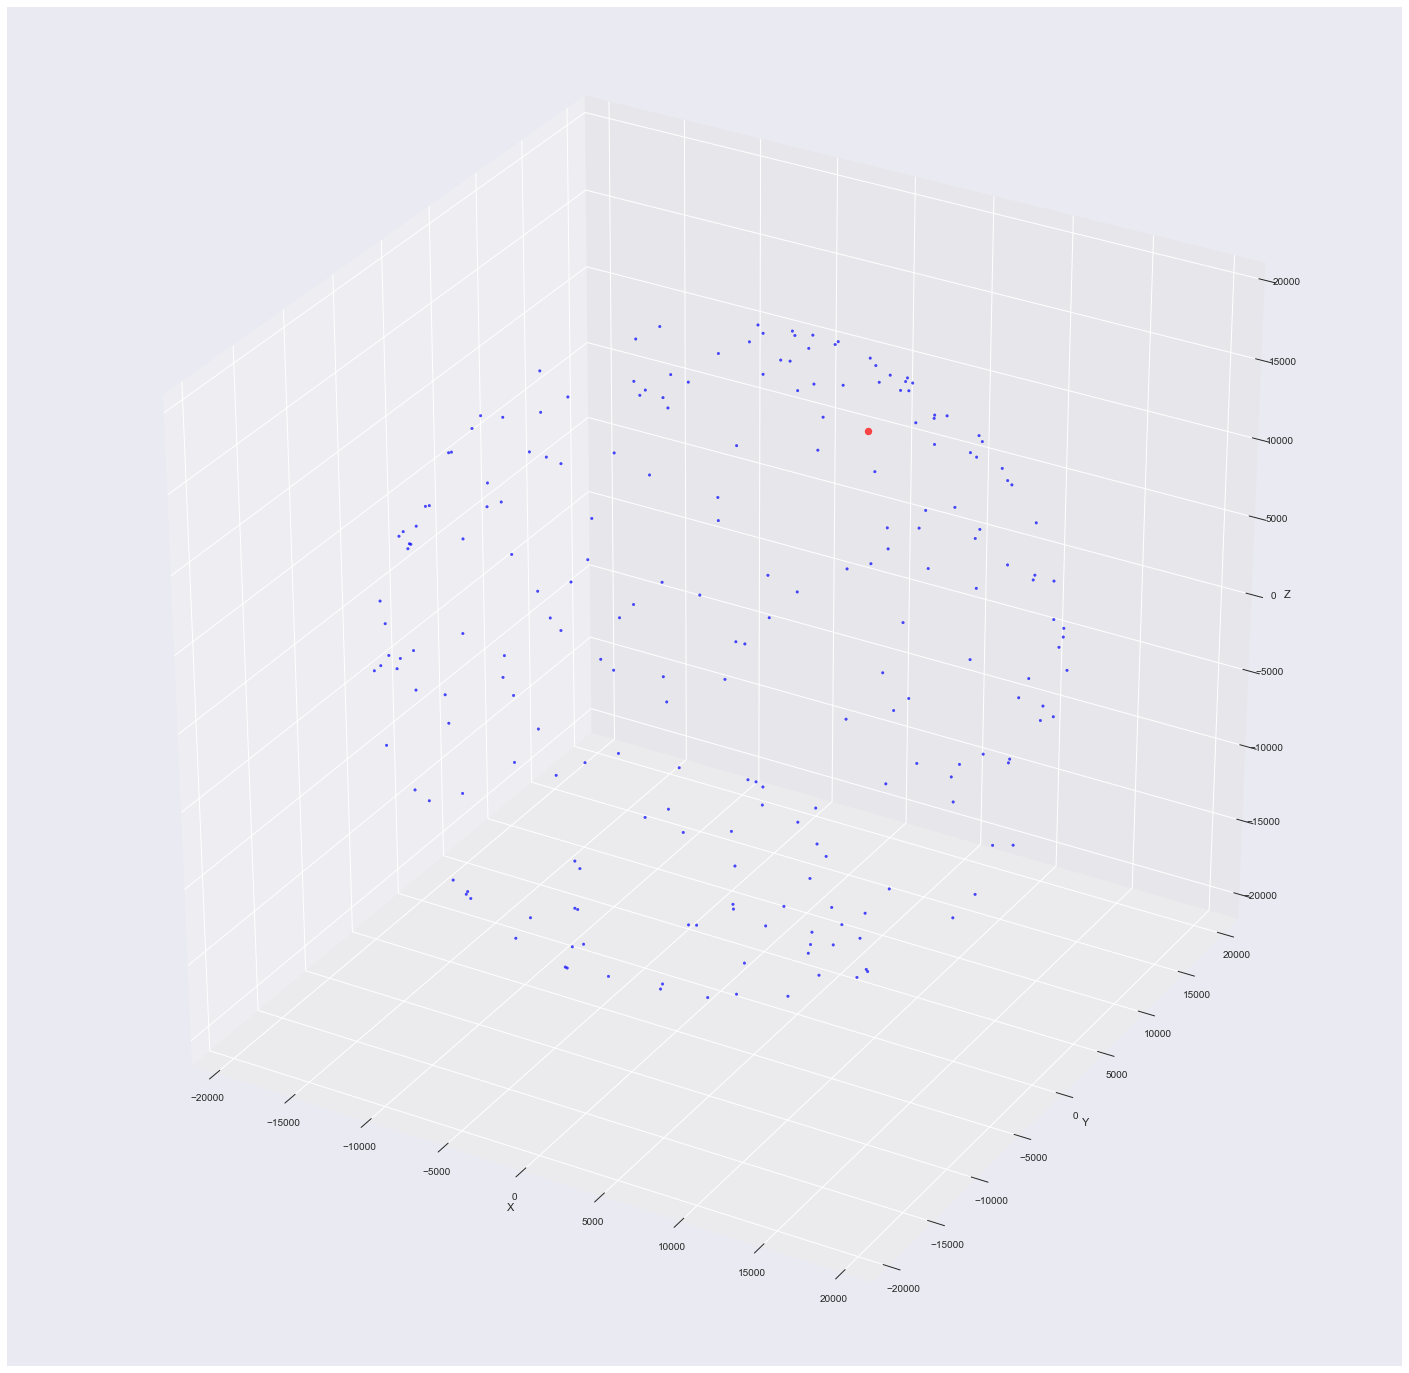

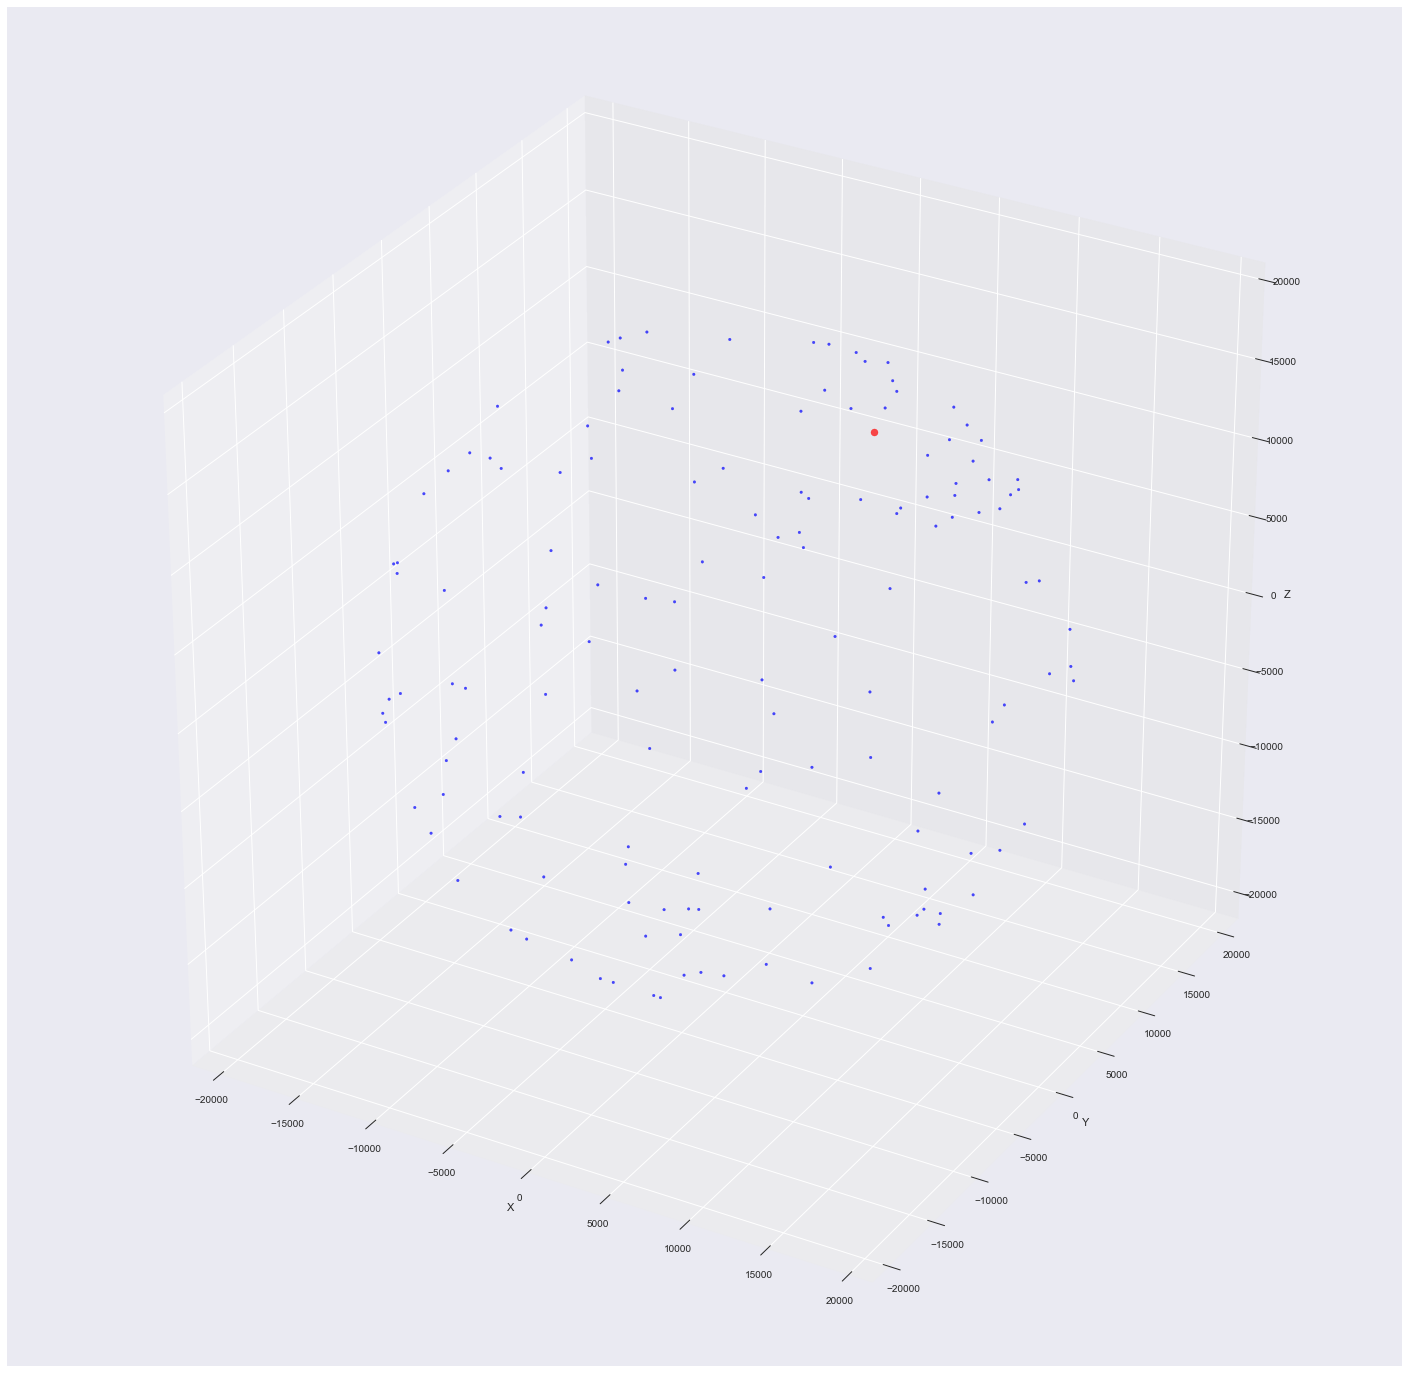

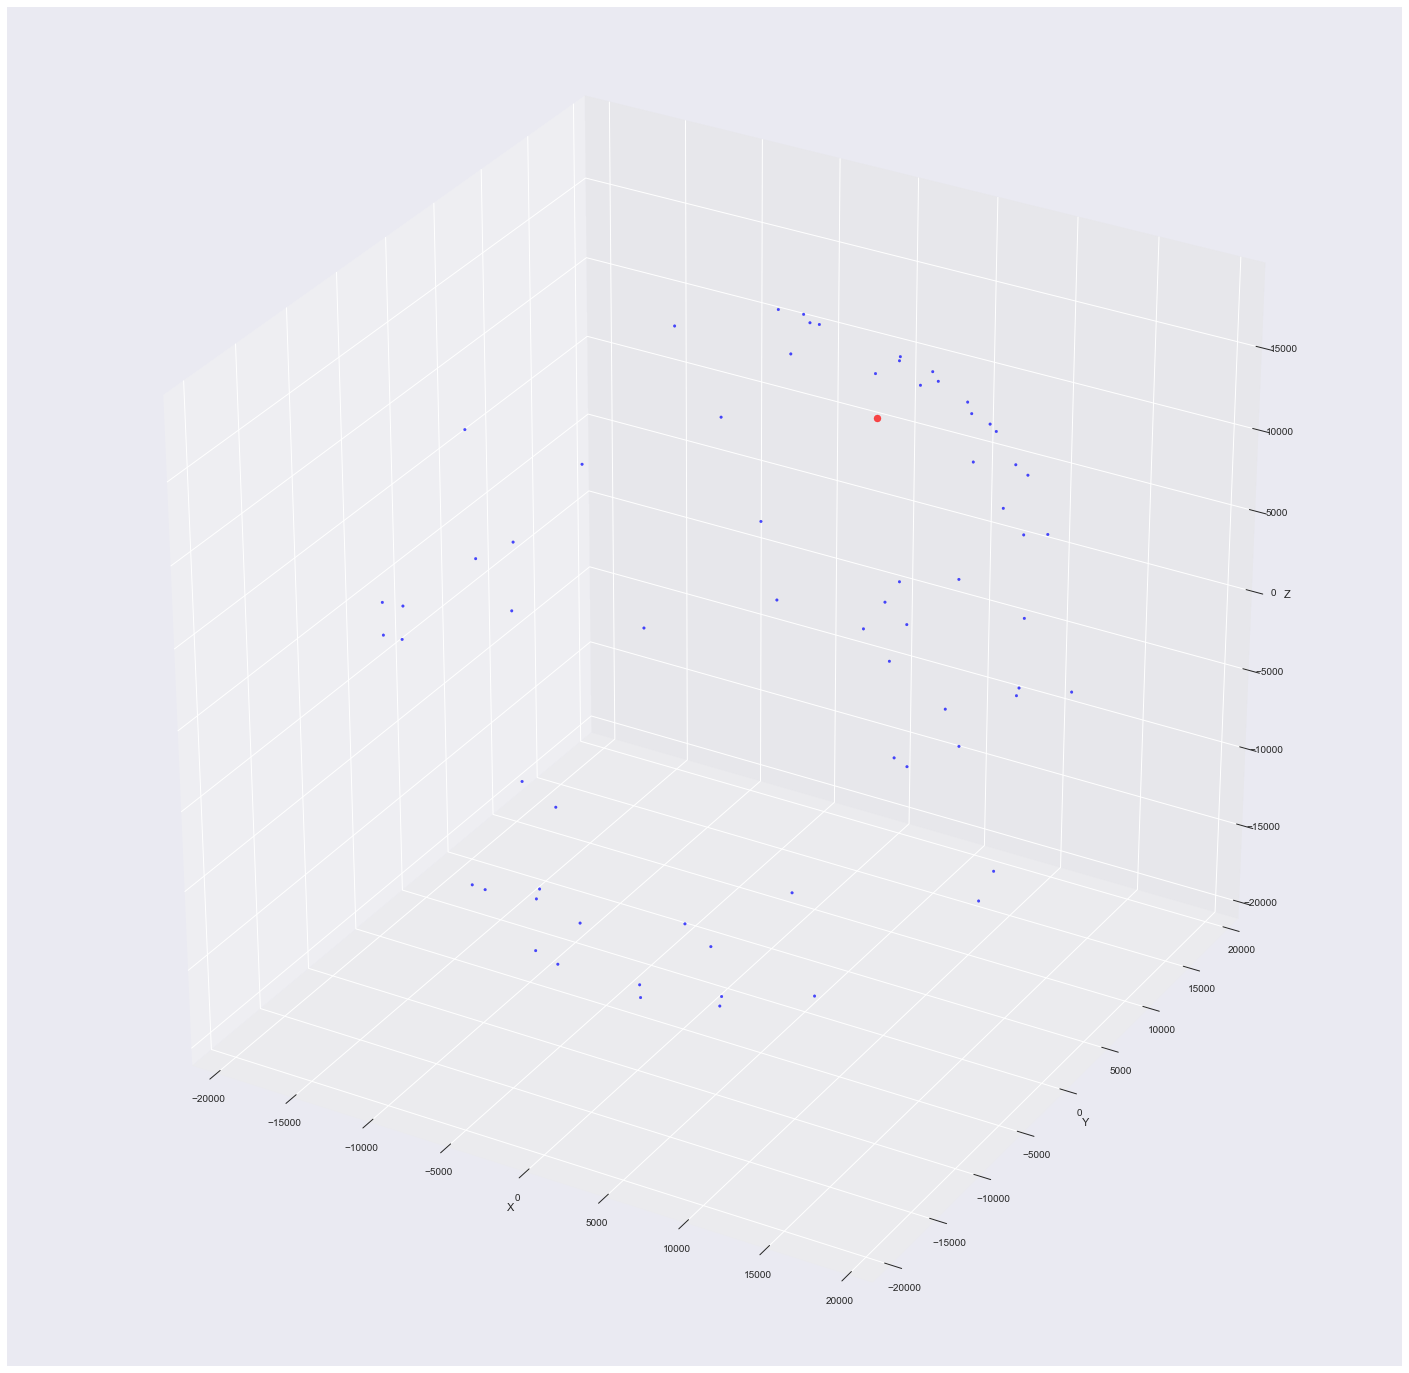

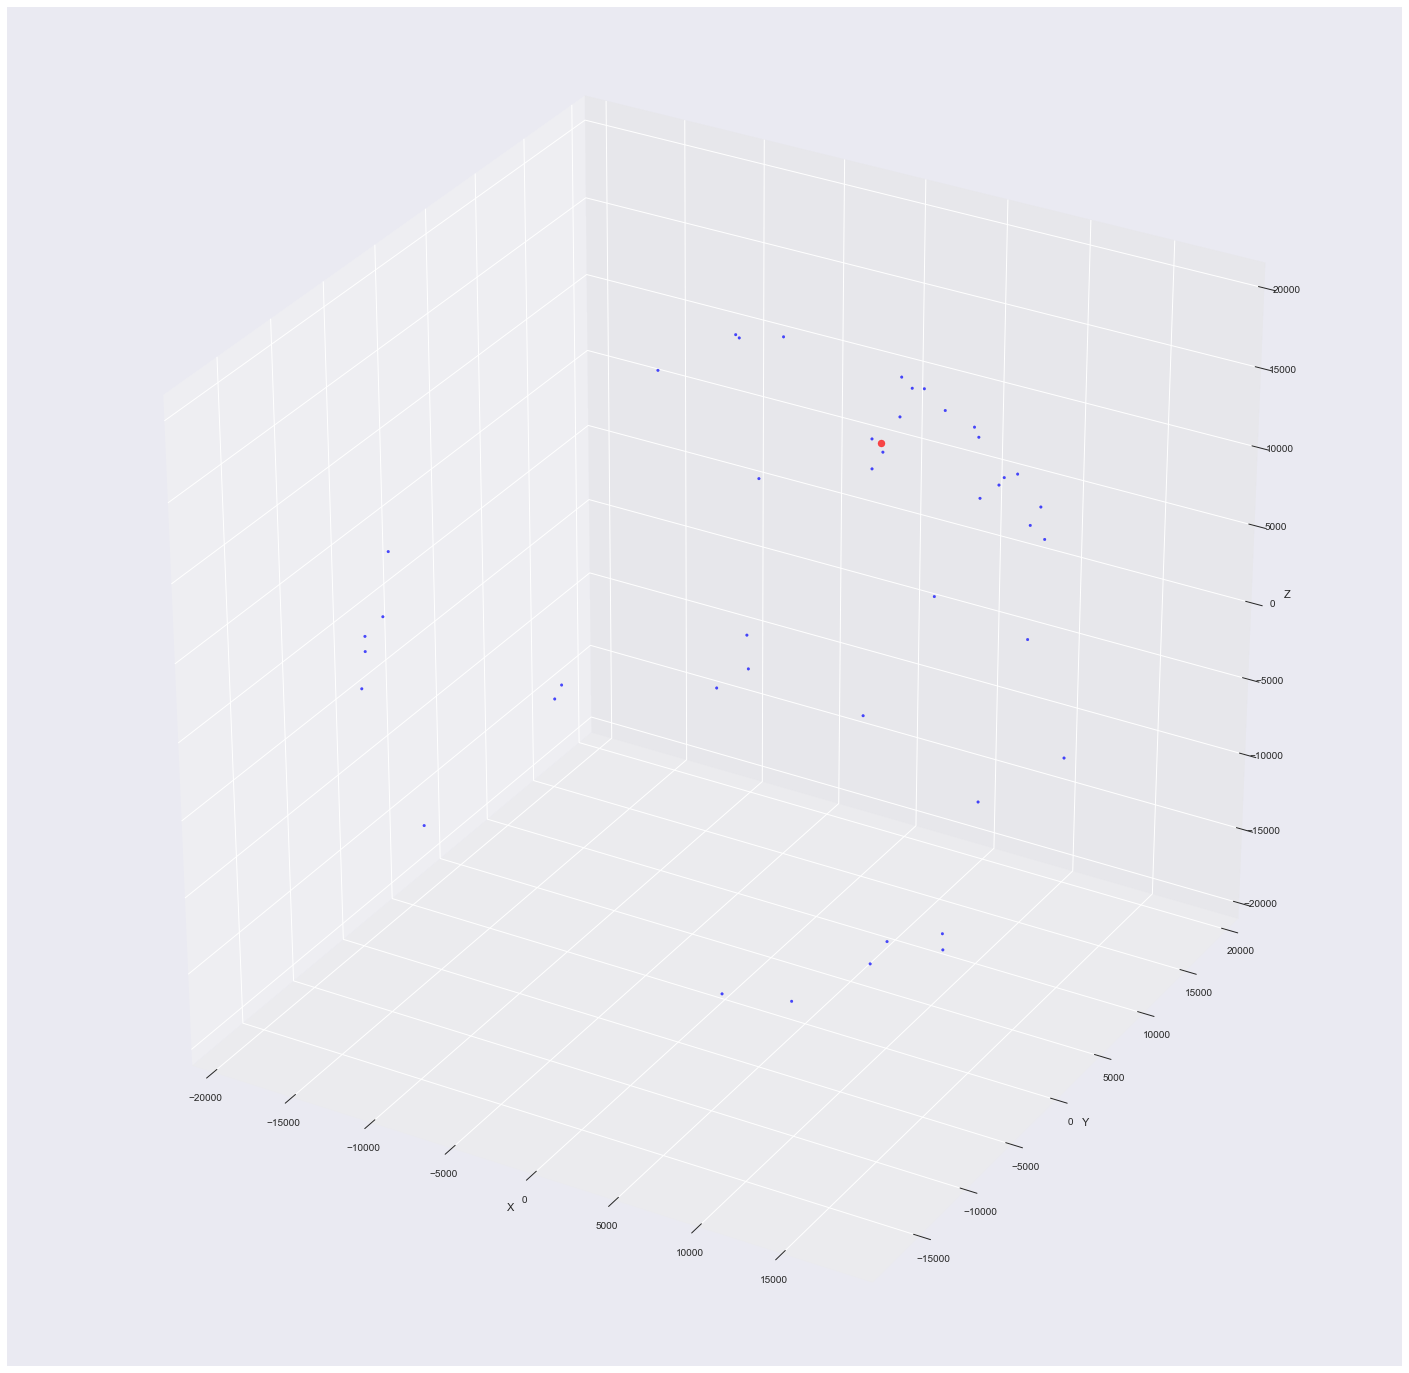

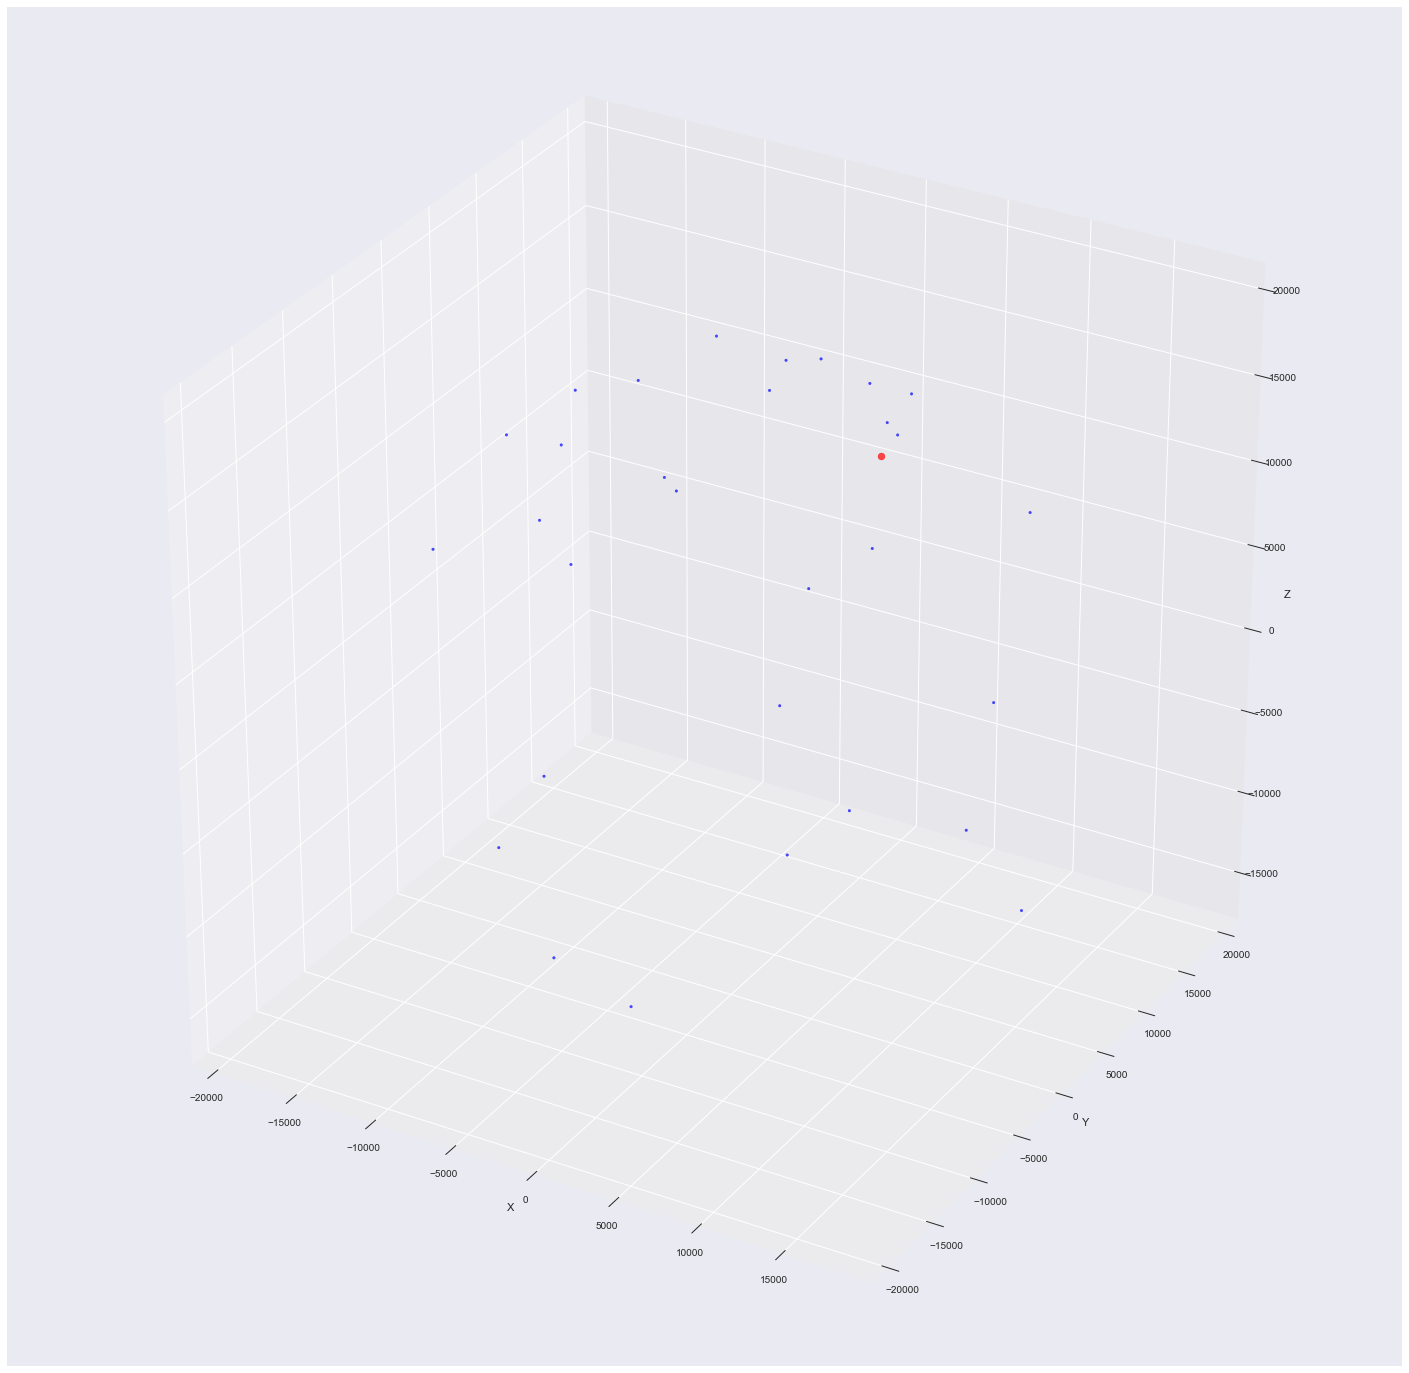

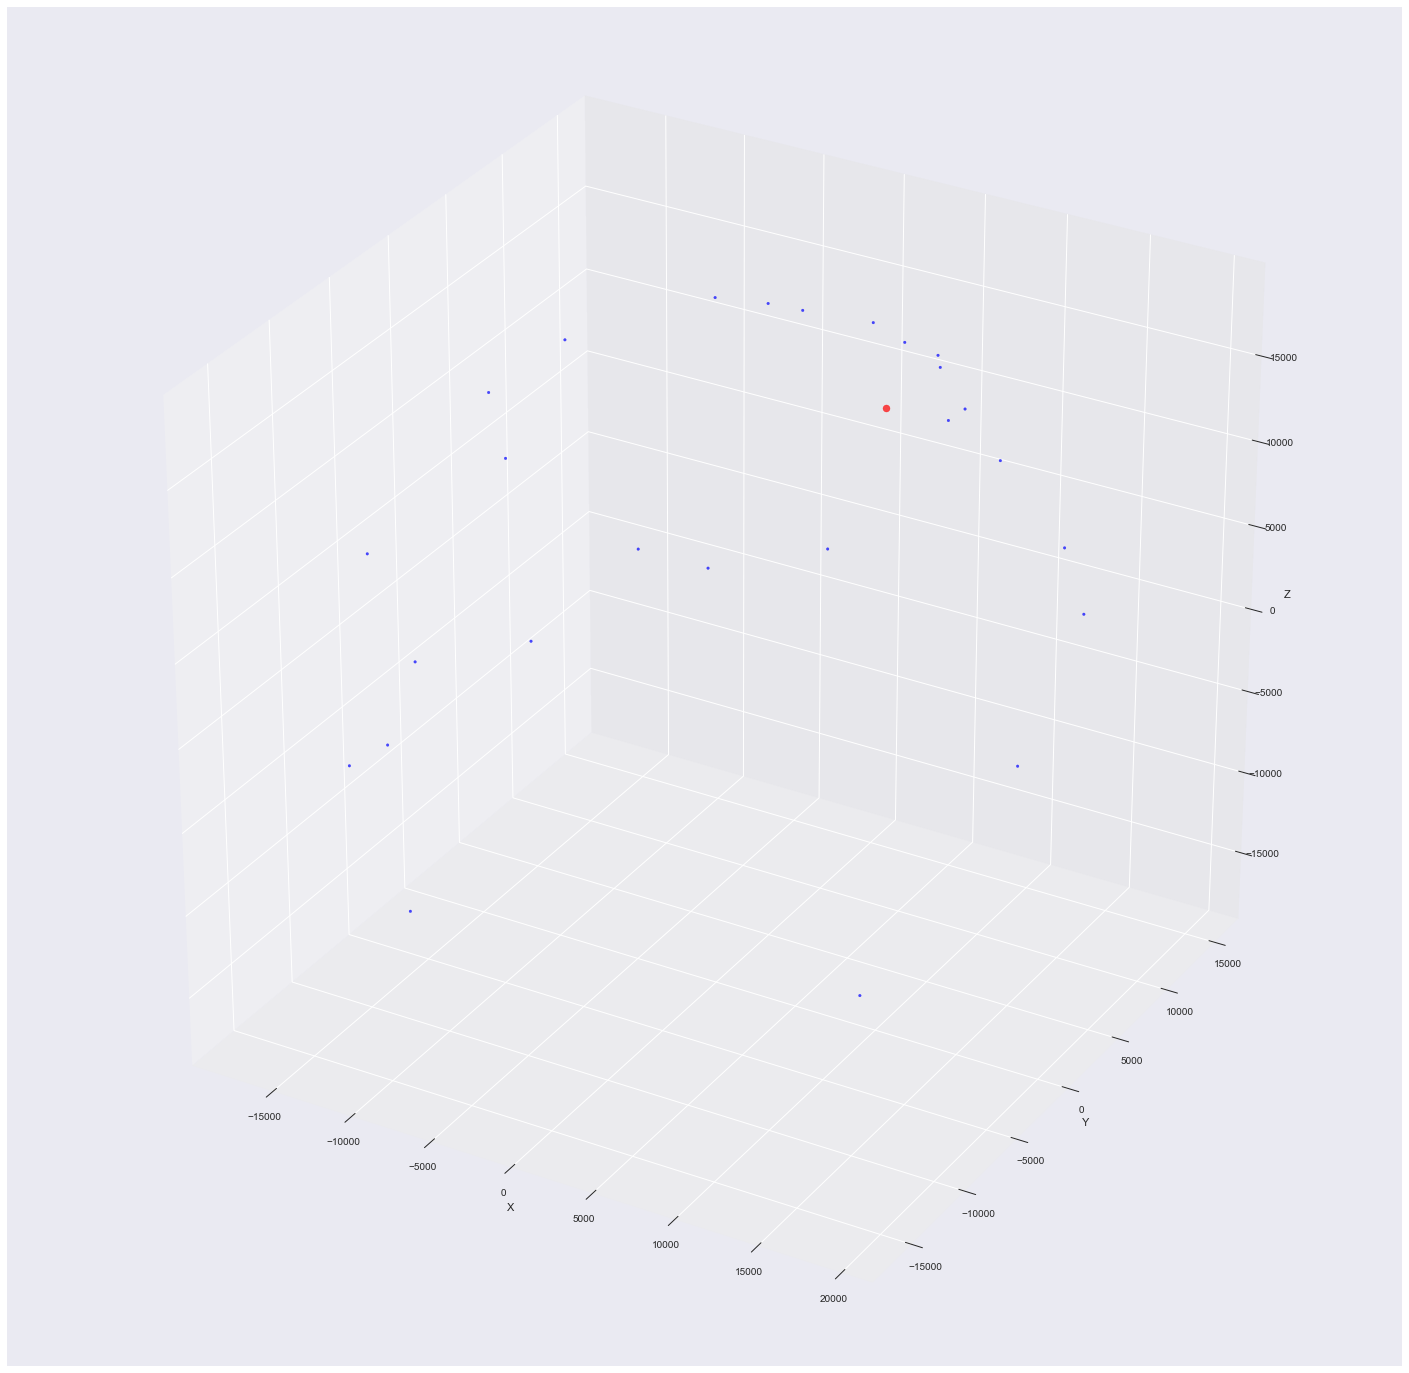

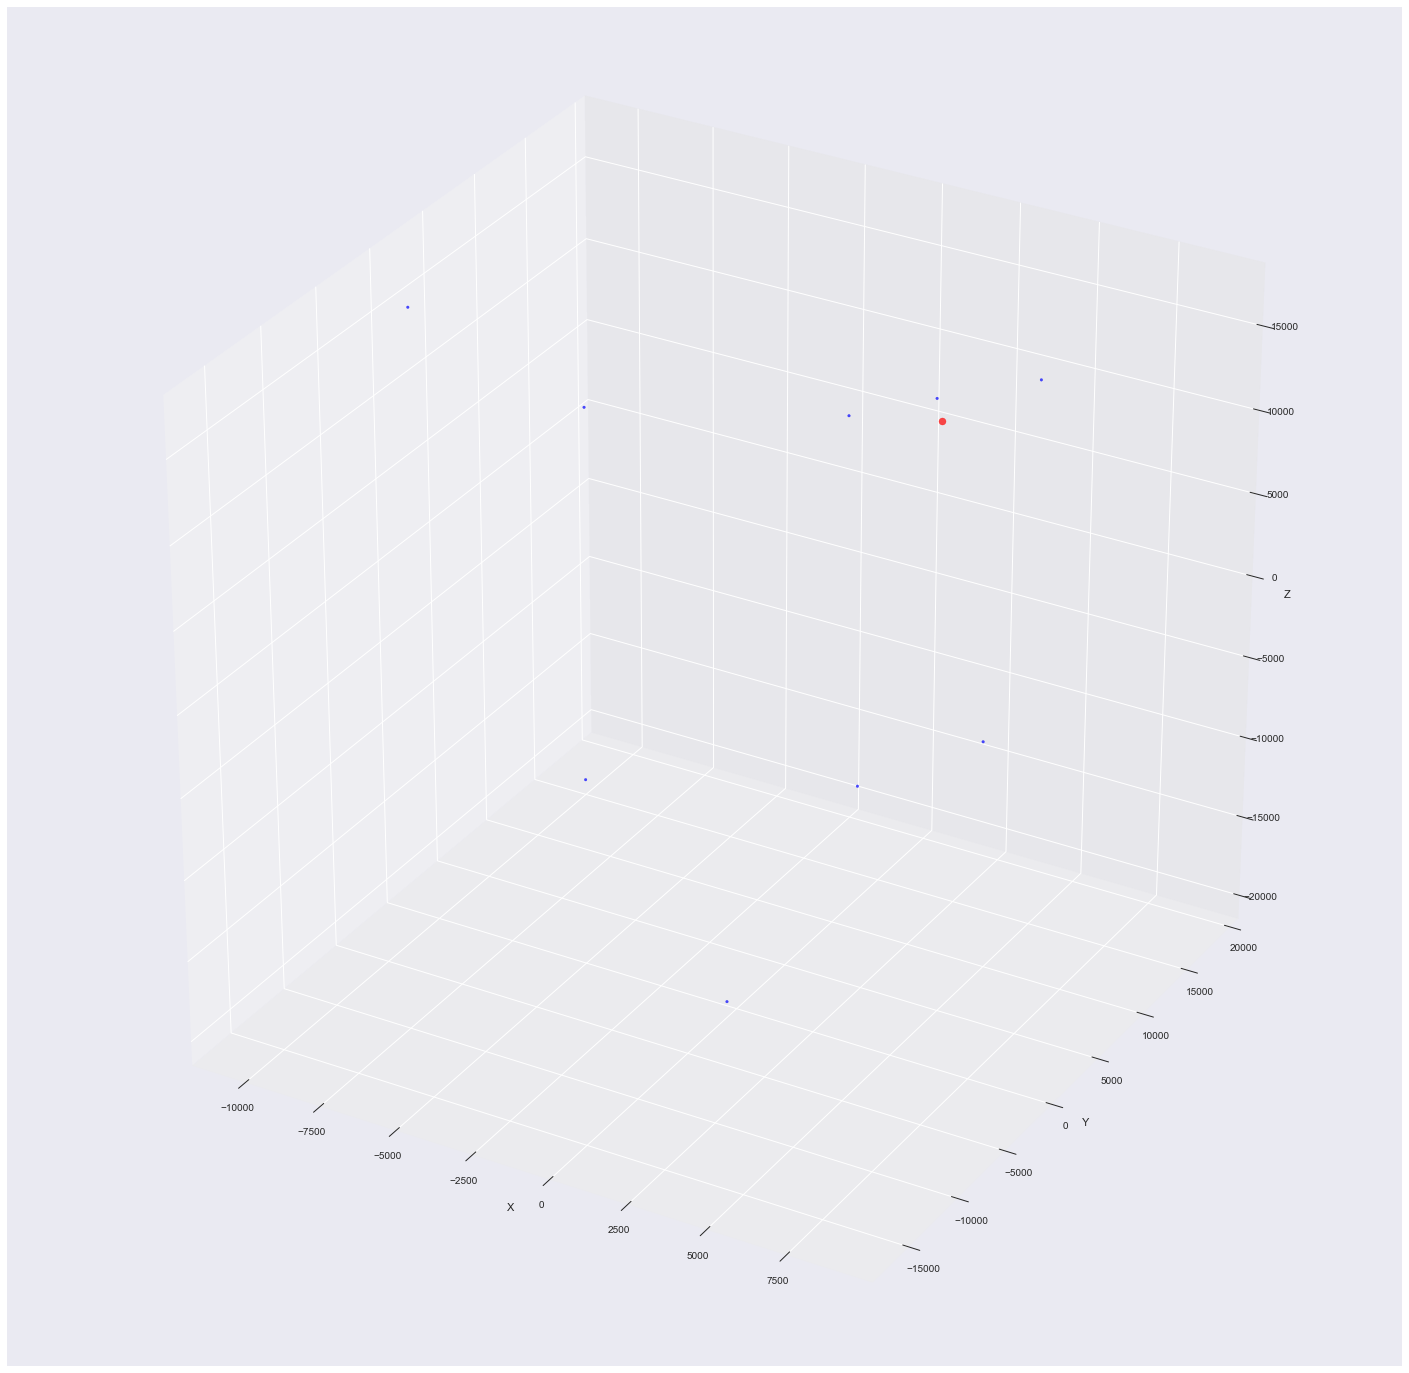

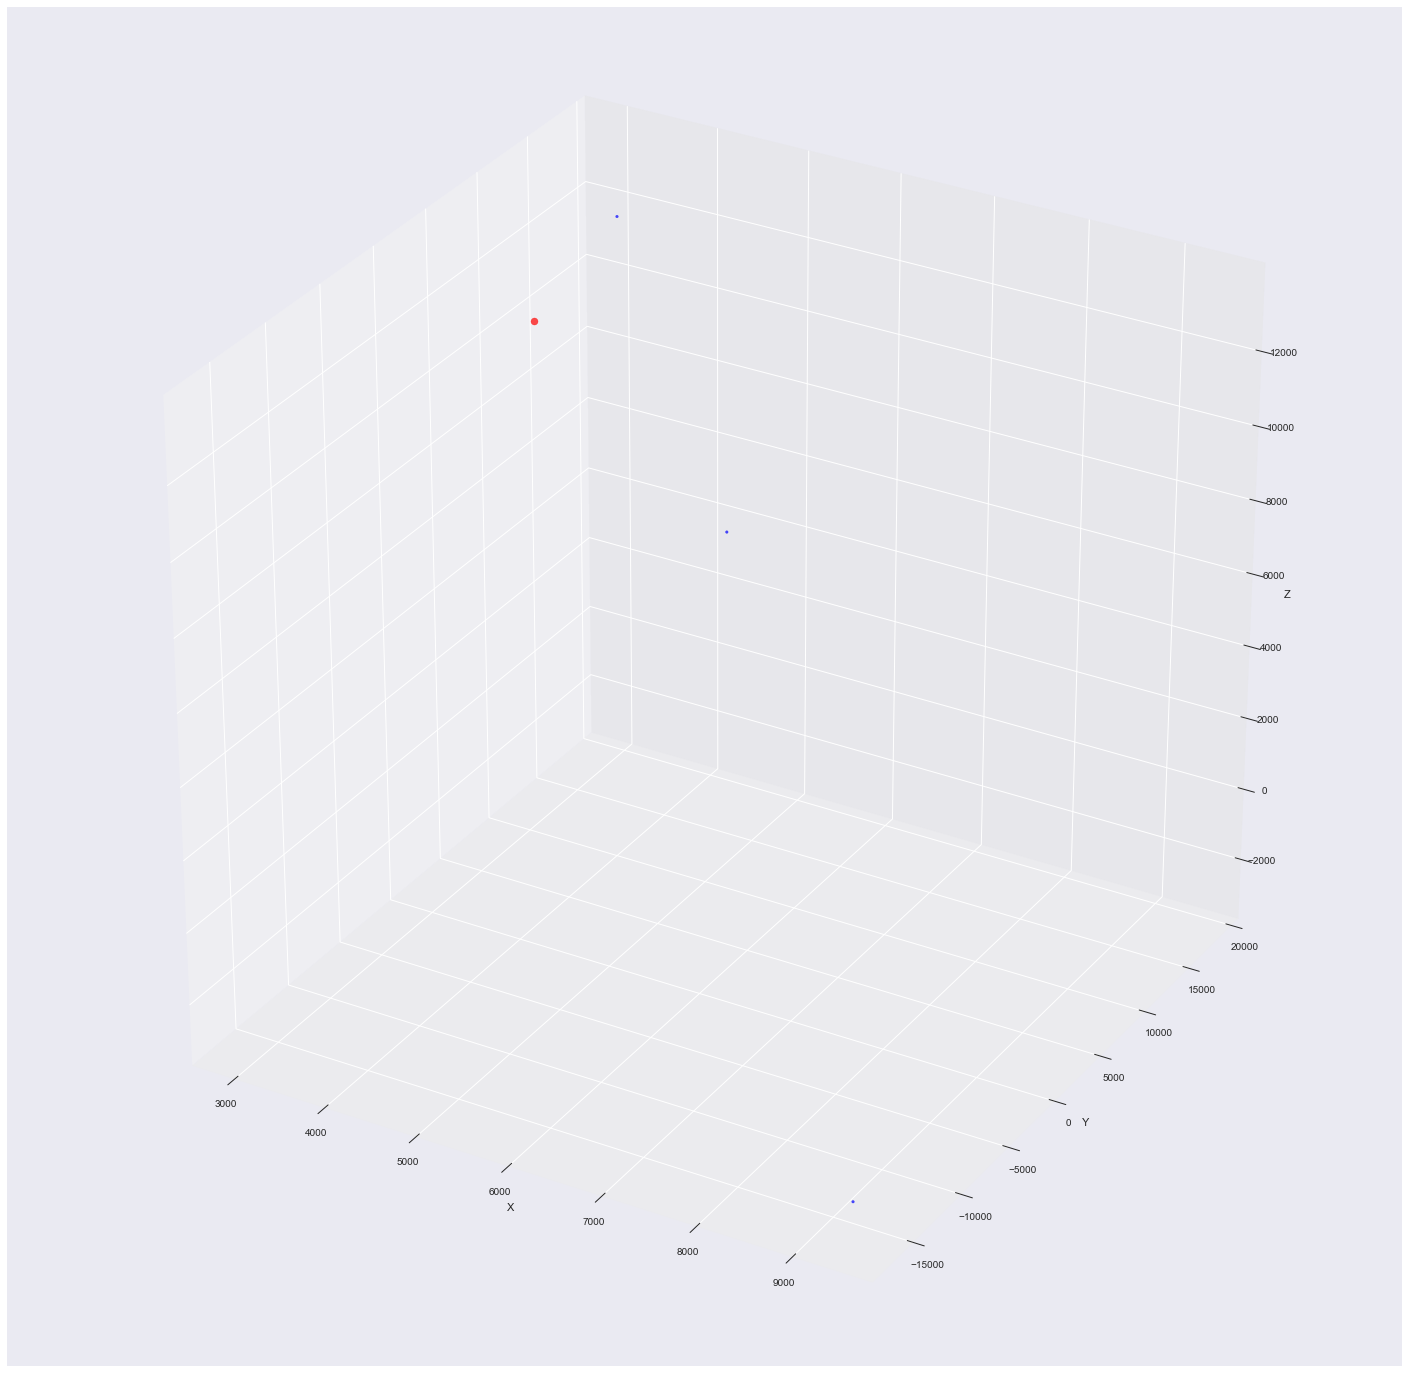

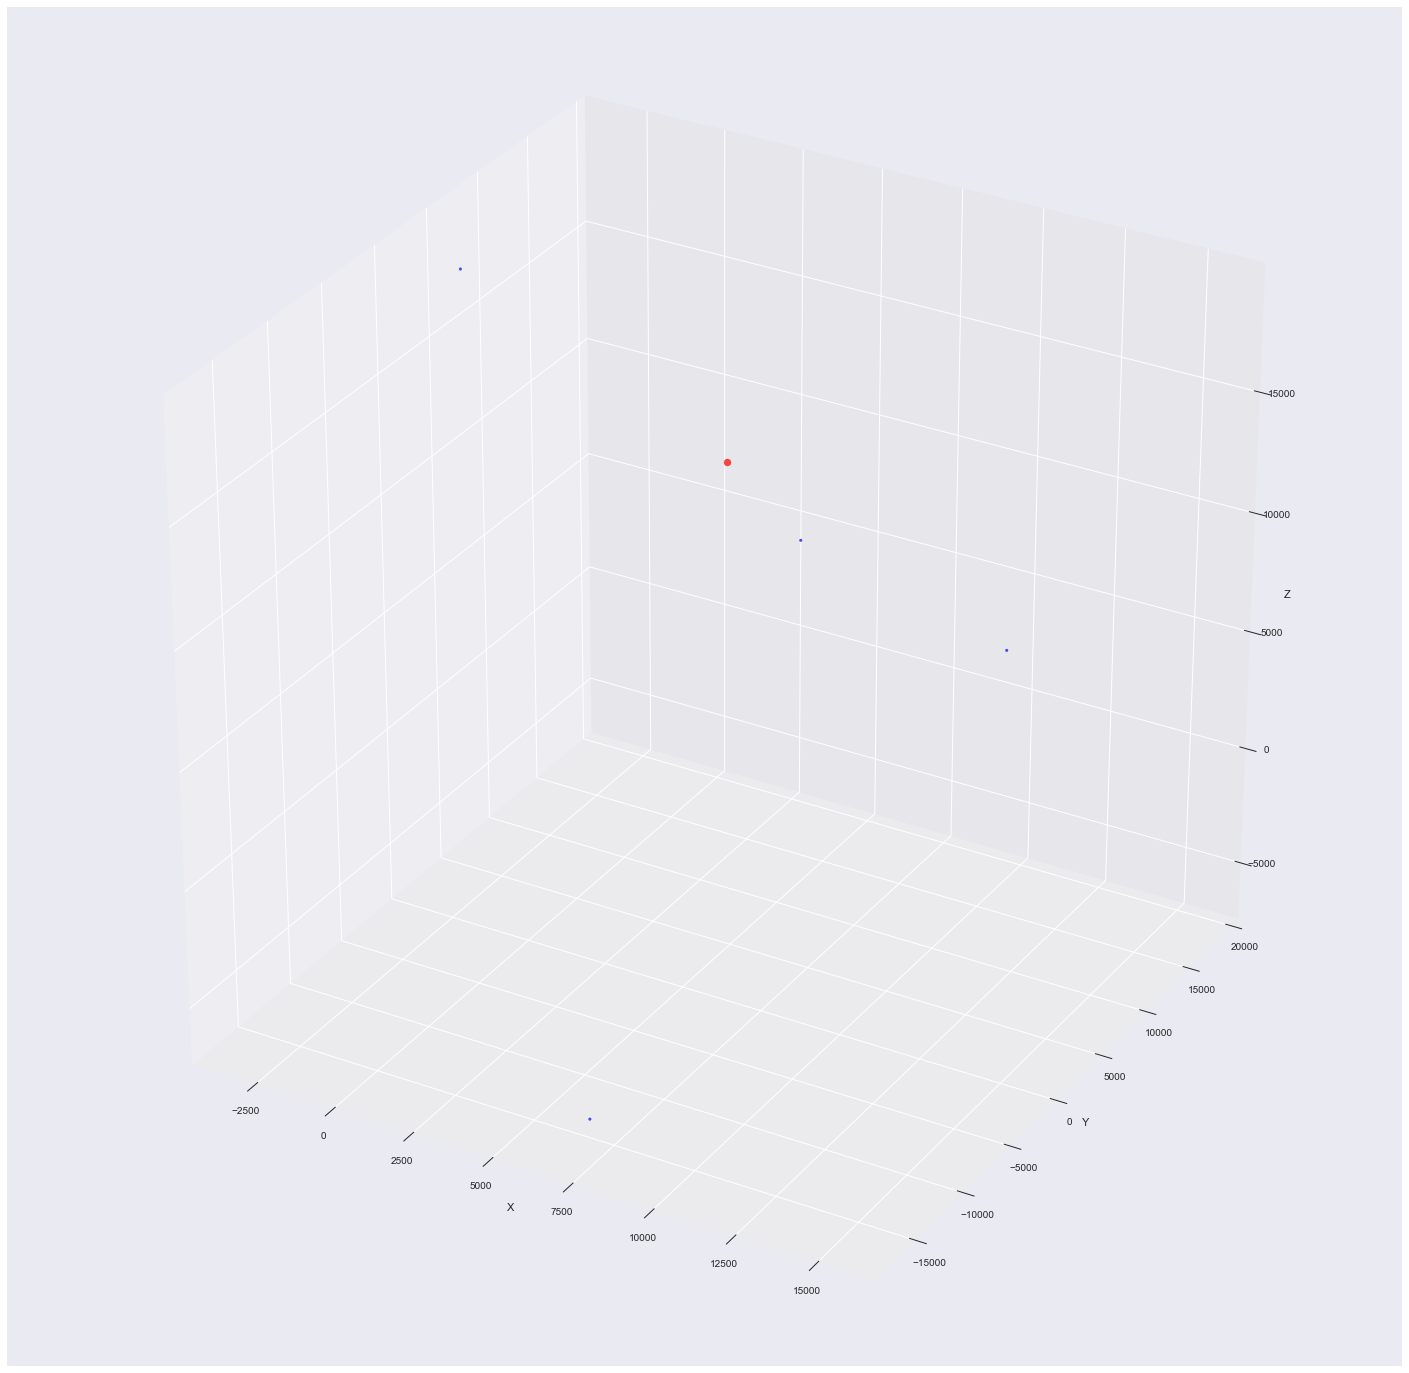

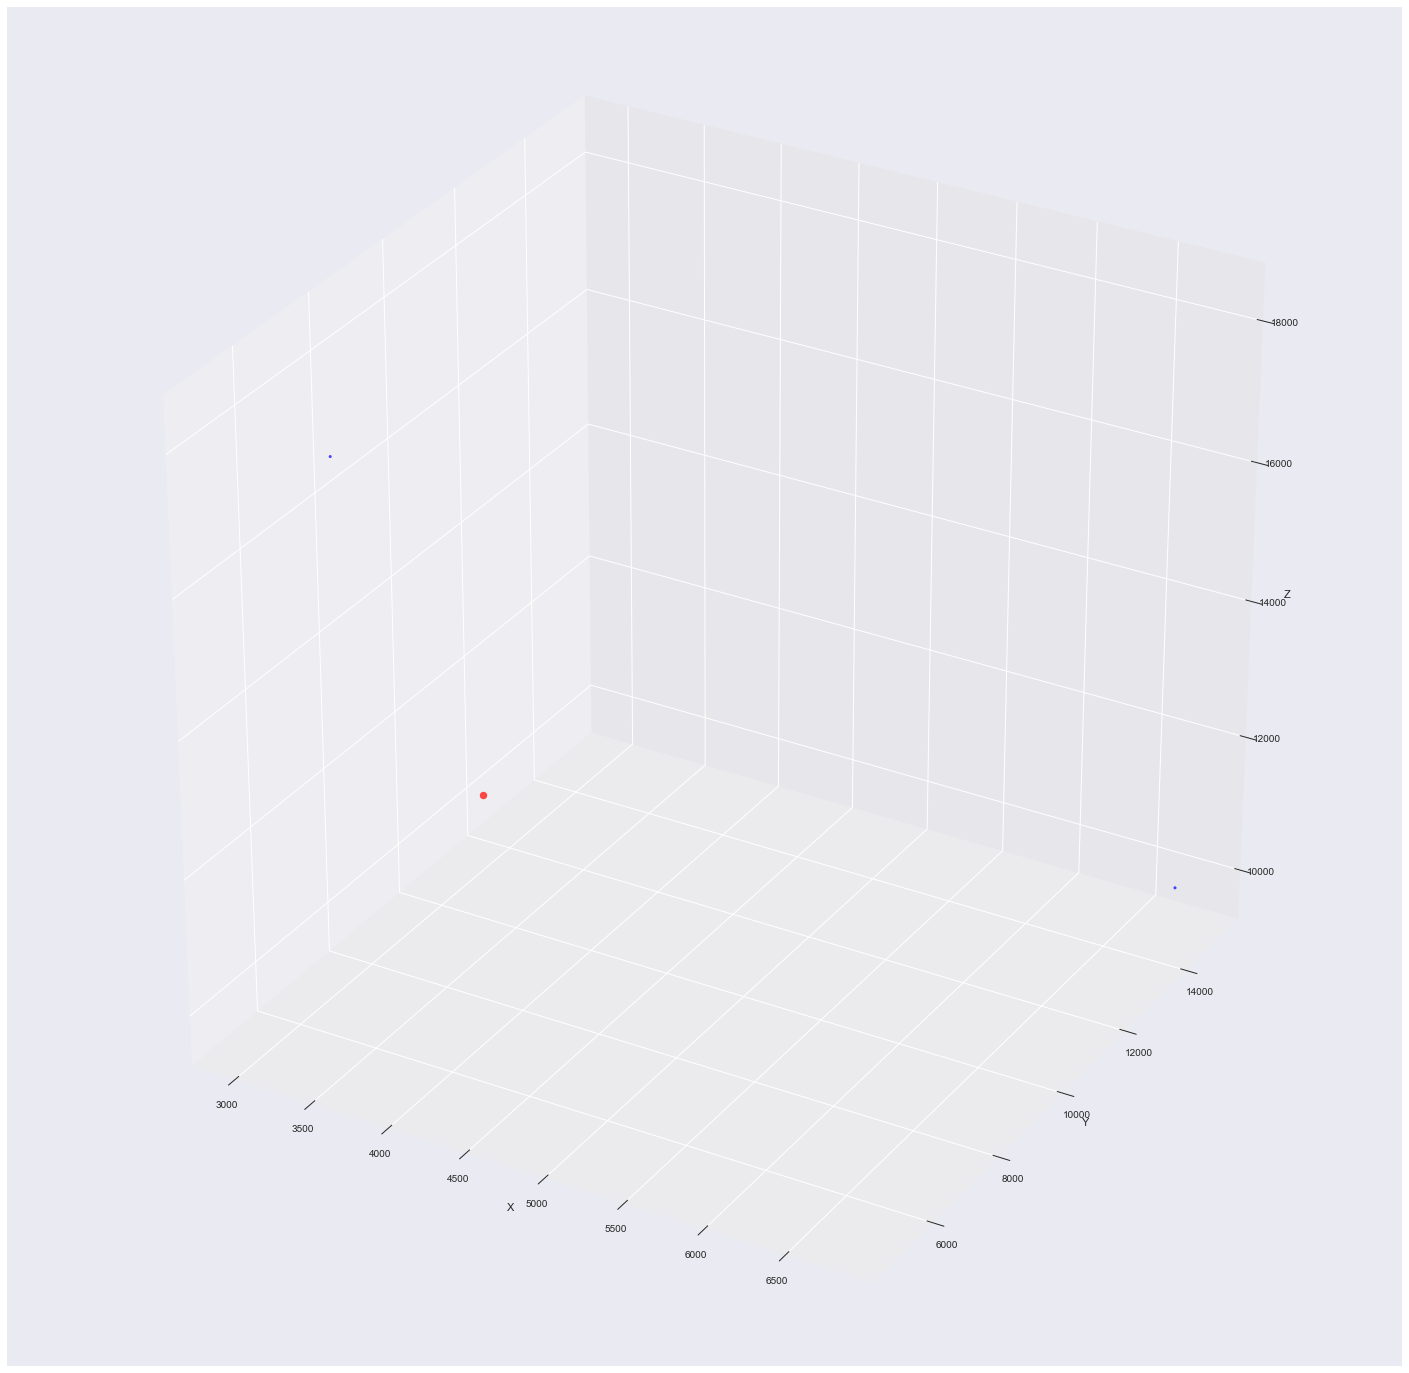

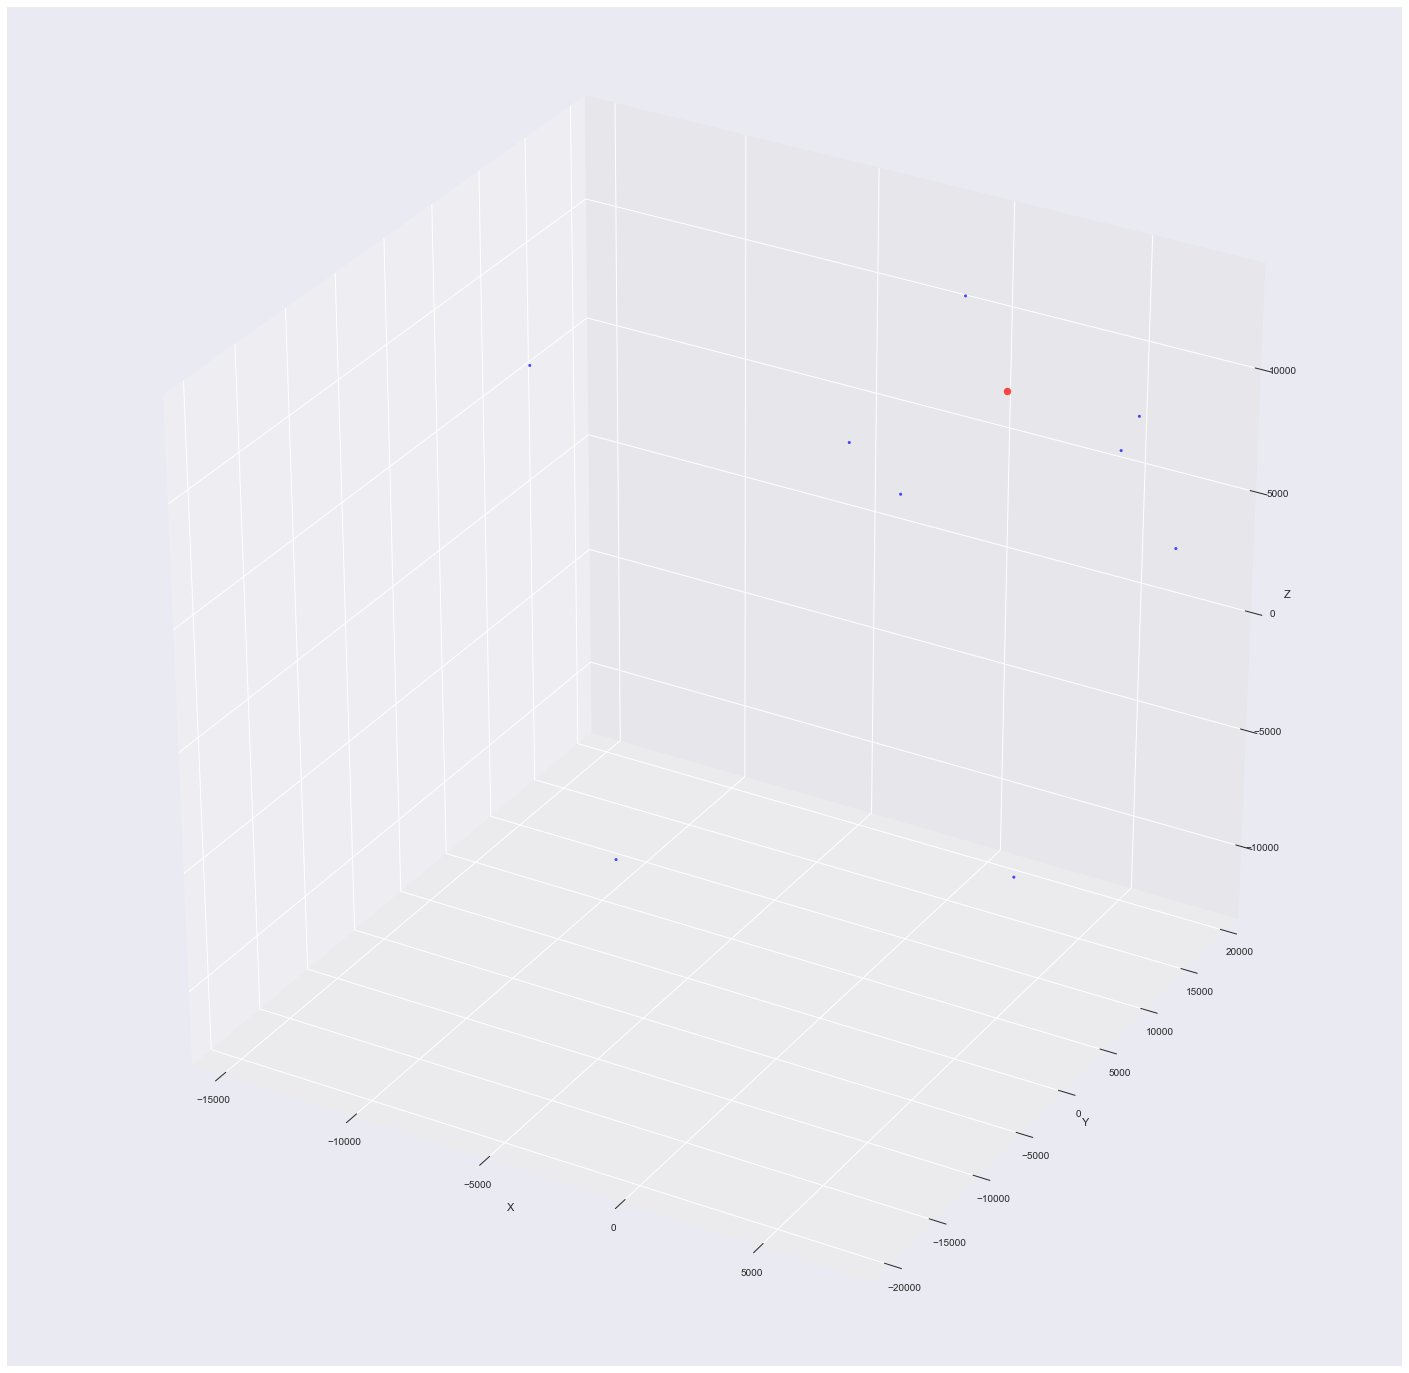

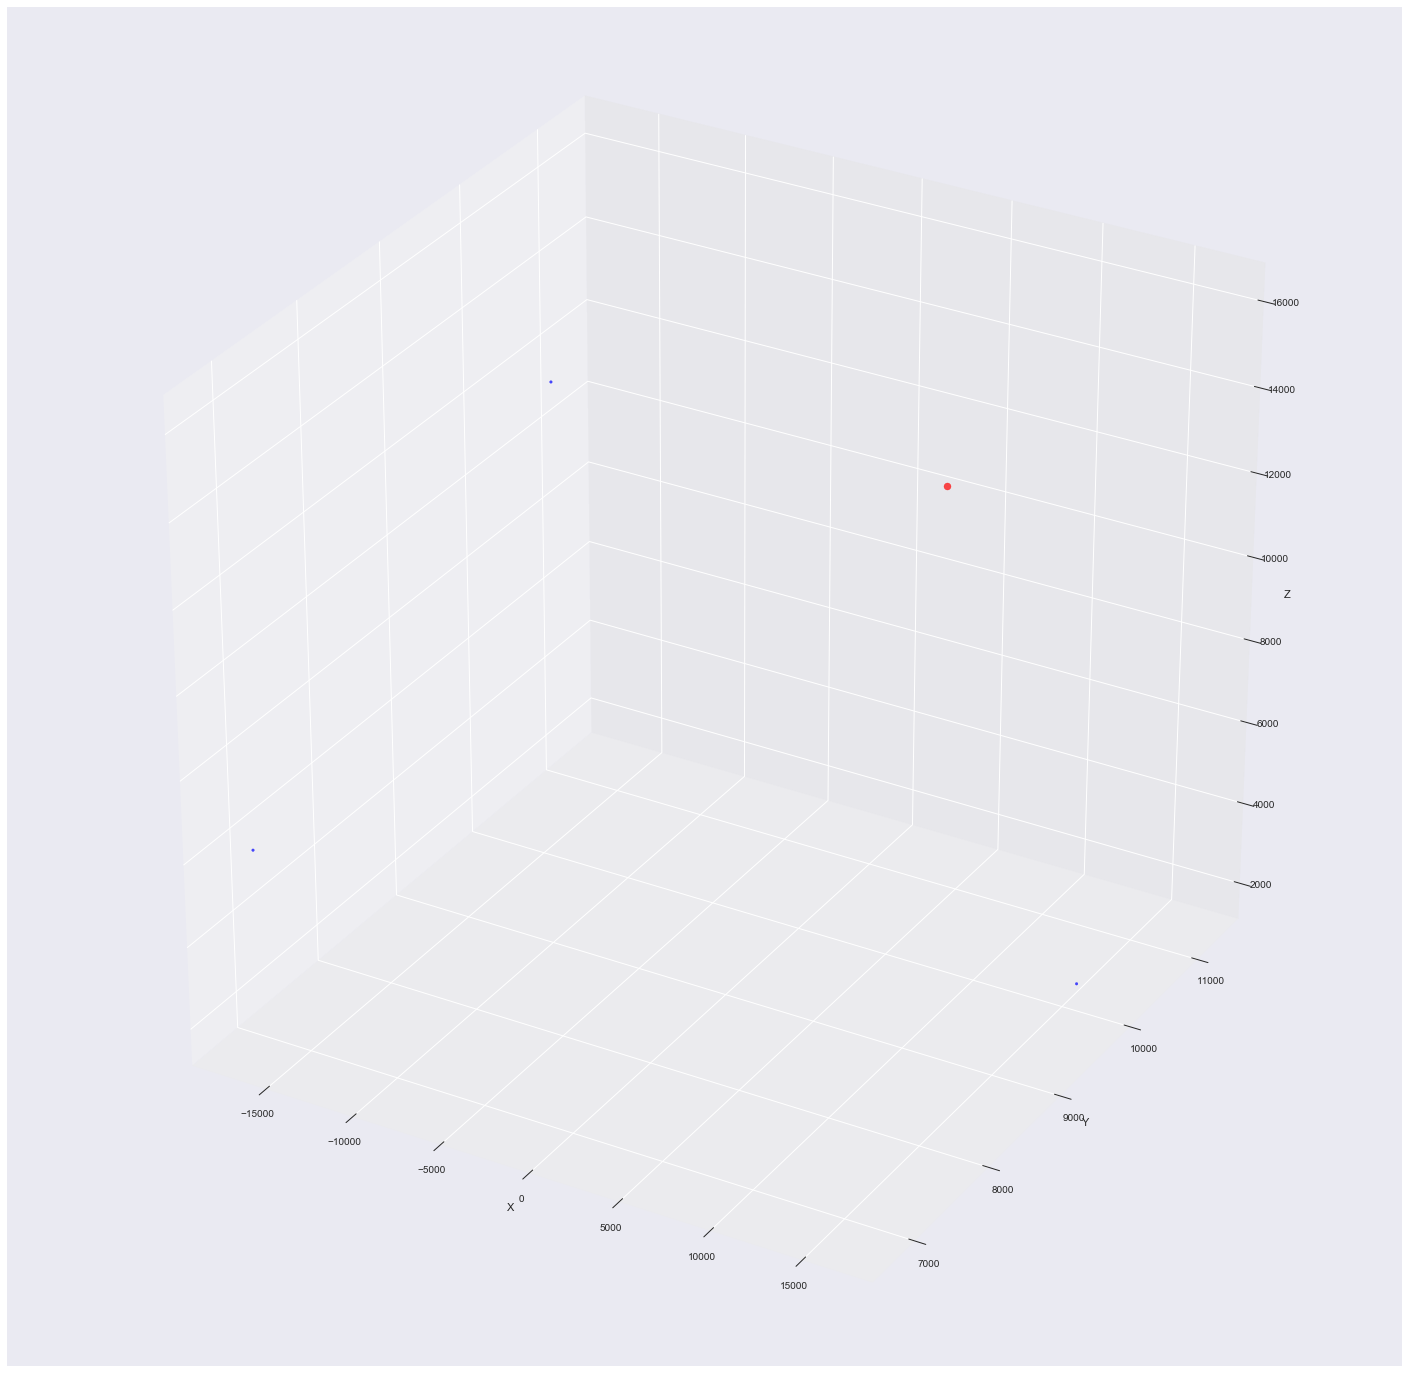

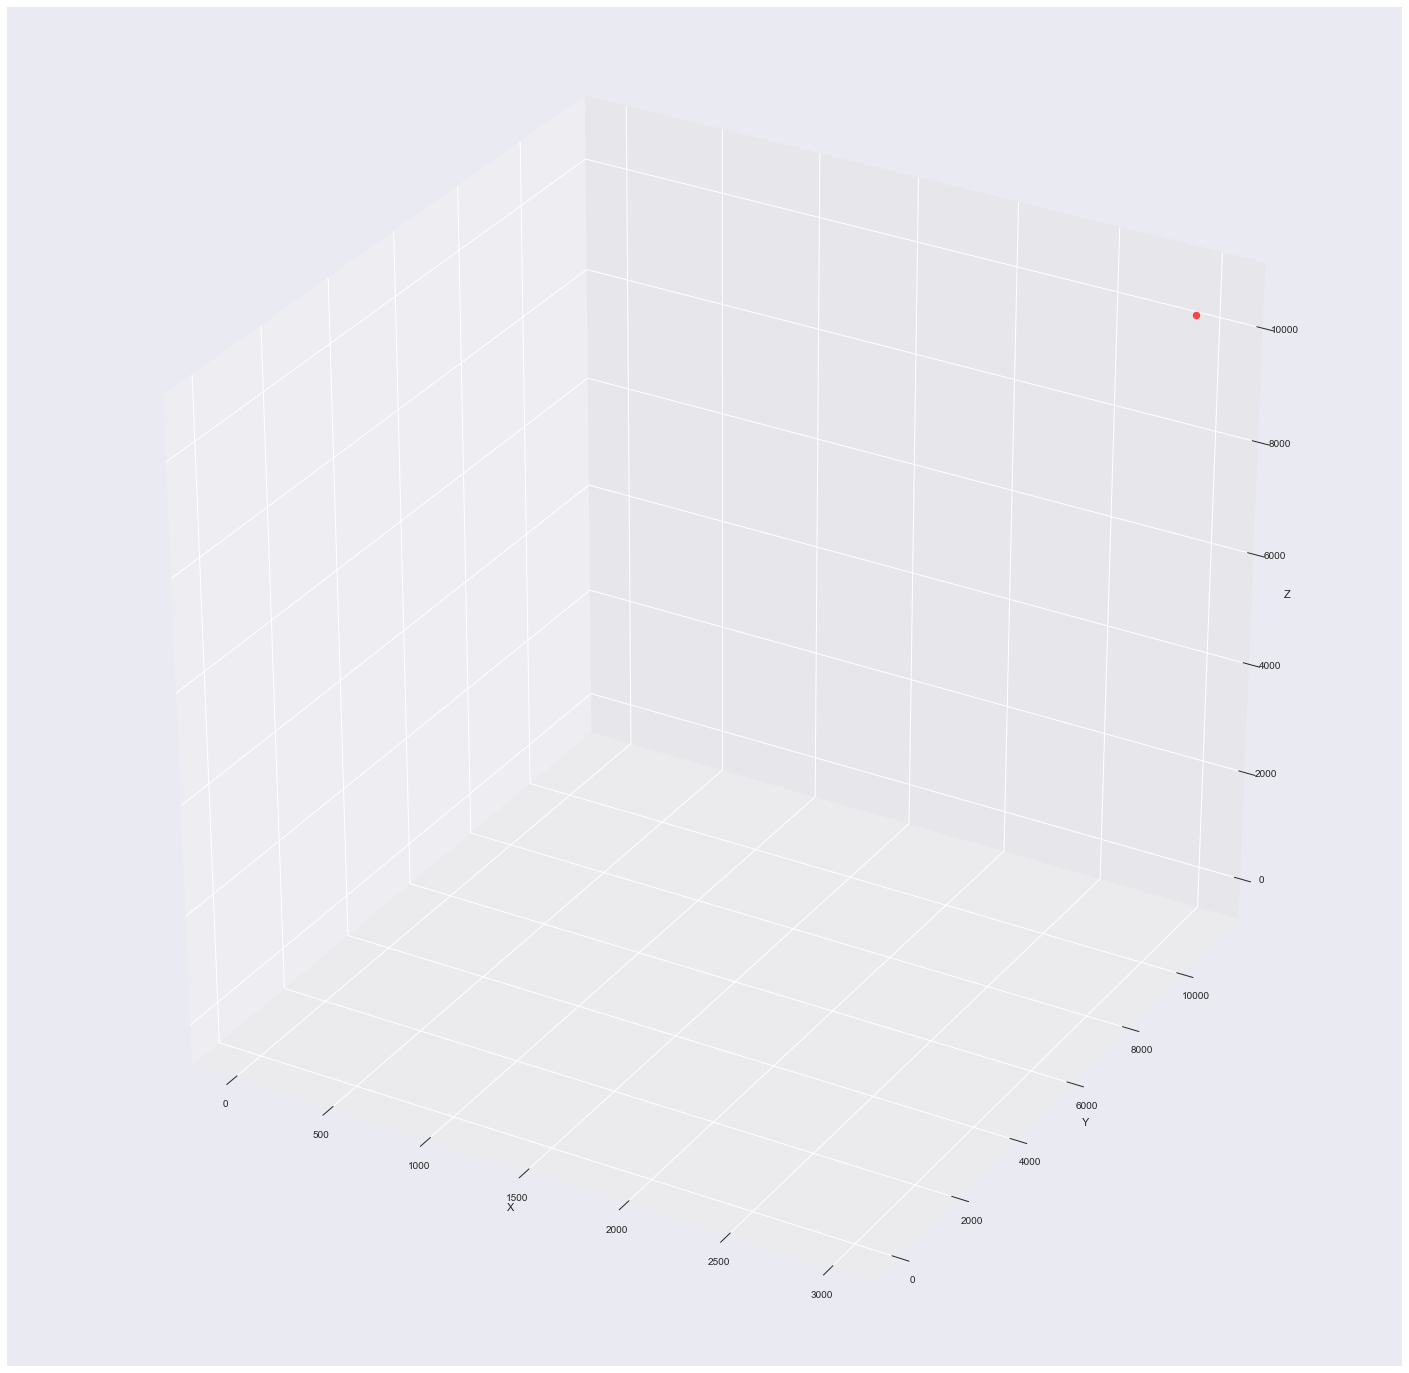

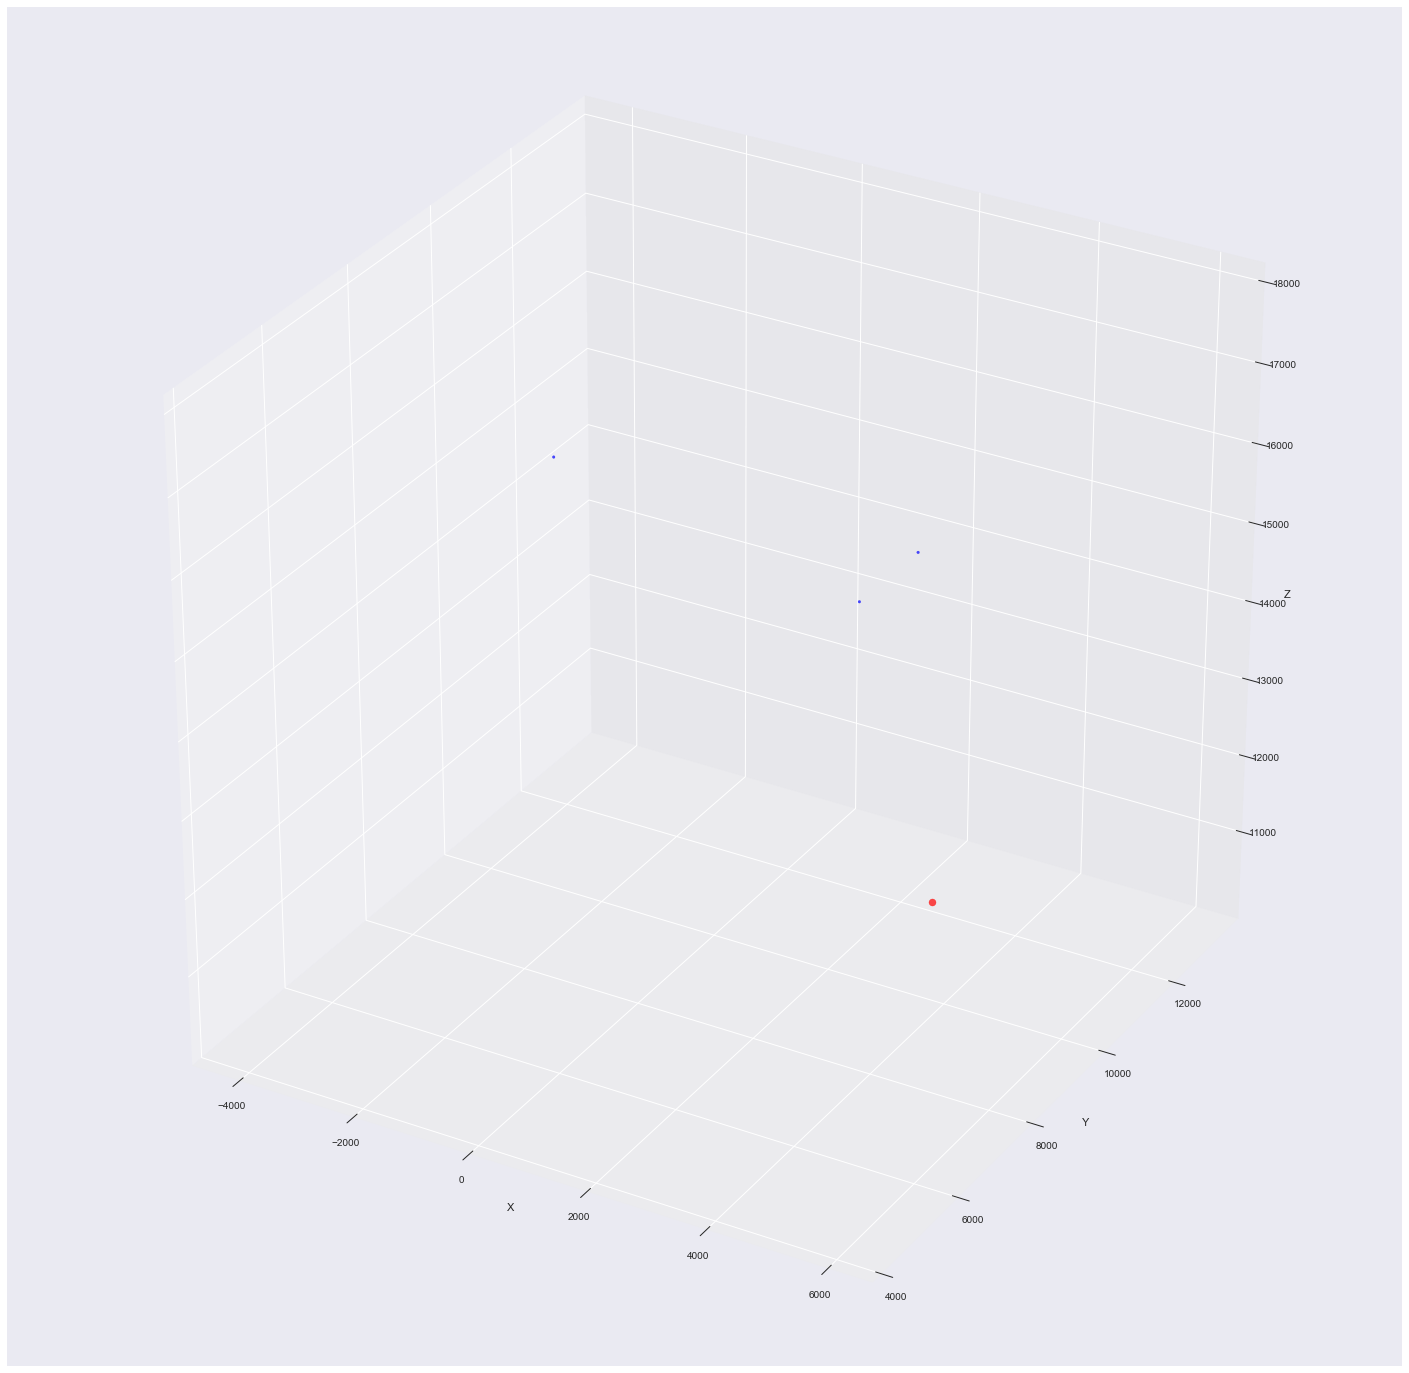

In [27]:
for i in range(n-1):
    ldf = lpmt_event_hits_without_DN[(lpmt_event_hits_without_DN['hitTime'] >= time_ints[i])
                                     & (lpmt_event_hits_without_DN['hitTime'] < time_ints[i+1])] 
    sdf = spmt_event_hits_without_DN[(spmt_event_hits_without_DN['hitTime'] >= time_ints[i])
                                     & (spmt_event_hits_without_DN['hitTime'] < time_ints[i+1])]
    
    l_hits = ldf['pmtID'].values
    s_hits = sdf['pmtID'].values
    
    if (l_hits.size < 200 & s_hits.size < 200): 
        break
        
    x = []
    y = []
    z = []
    
    for t in lpmt_pos.itertuples():
        if t[1] in l_hits:
            x.append(t[2])
            y.append(t[3])
            z.append(t[4])
        
    for t in spmt_pos.itertuples():
        if t[1] in s_hits:
            x.append(t[2])
            y.append(t[3])
            z.append(t[4])
    
    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='b', marker='o', s=7, alpha=0.7)
    
    ax.scatter(true_event[0], true_event[1], true_event[2], c='r', marker='o', s=50, alpha=0.7)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [28]:
from ipywidgets import Button, Layout

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def rotate(data, r0, r1):
    a1 = r0 * np.pi
    
    data = np.dot(np.array(
        [[1,          0,           0],
         [0, np.cos(a1), -np.sin(a1)],
         [0, np.sin(a1),  np.cos(a1)]]
        
    ), data)
    
    a2 = r1 * np.pi
    
    data = np.dot(np.array(
        [[ np.cos(a2), 0,  np.sin(a2)],
         [          0, 1,           0],
         [-np.sin(a2), 0,  np.cos(a2)]]
        
    ), data)

    return data

def genrate_equator():
    data = np.zeros((3, 1001))
    
    r = 19000.0
    
    for i in range(1001):
        a = i / 1000 * 2 * np.pi
        data[0, i] = np.sin(a) * r
        data[1, i] = np.cos(a) * r

    return data

def f(t0, t1, r0, r1):    
    ldf = lpmt_event_hits_without_DN
    sdf = spmt_event_hits_without_DN
    
    color = []
    size = []
    
    for m in ((lpmt_event_hits_without_DN['hitTime'] >= t0)
            & (lpmt_event_hits_without_DN['hitTime'] <= t1)).values:
        color.append('b' if m else 'g')
        size.append(5.0 if m else 1)

    
    for m in ((spmt_event_hits_without_DN['hitTime'] >= t0)
            & (spmt_event_hits_without_DN['hitTime'] <= t1)).values:
        color.append('b' if m else 'g')
        size.append(5.0 if m else 1)
    
    l_hits = ldf['pmtID'].values
    s_hits = sdf['pmtID'].values
    
    
    x = []
    y = []
    z = []
    
    for t in lpmt_pos.itertuples():
        if t[1] in l_hits:
            x.append(t[2])
            y.append(t[3])
            z.append(t[4])
        
    for t in spmt_pos.itertuples():
        if t[1] in s_hits:
            x.append(t[2])
            y.append(t[3])
            z.append(t[4])
            
    data = np.stack([x, y, z], axis=0)
    
    data = rotate(data, r0, r1)
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    ax.scatter(data[0], data[1], c=color, marker='o', s=size)
    
    
    te = np.array([true_event[0], true_event[1], true_event[2]])
    
    te = rotate(te, r0, r1)
    
    ax.scatter(te[0], te[1], c='r', marker='o', s=50, alpha=0.7)

    eq = genrate_equator()
    
    eq = rotate(eq, r0, r1)
    
    ax.plot(eq[0], eq[1], 'r--', c=(0.5, 0.5, 0.5))
    
    plt.show()

    
interactive_plot = interactive(f, 
                               t0= widgets.FloatSlider(min=min(lpmt_time),max=max(lpmt_time),value=min(lpmt_time),
                                                     layout=Layout(width='80%')), 
                               t1= widgets.FloatSlider(min=min(lpmt_time),max=max(lpmt_time),value=max(lpmt_time),
                                                     layout=Layout(width='80%')), 
                               r0 = widgets.FloatSlider(min=-1,max=1,value=0, step=0.01,
                                                     layout=Layout(width='80%')), 
                               r1 = widgets.FloatSlider(min=-1,max=1,value=0, step=0.01,
                                                     layout=Layout(width='80%')))
output = interactive_plot.children[-1]
output.layout.height = '750px'
interactive_plot
